# Post

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from joblib import Parallel, delayed

sns.set()
P = '#7B73F0'
G = '#27DDCB'

## Load Words

In [2]:
with open('data/wordle-candidates.json', 'r') as file:
    wordle_candidates = json.load(file)
    
with open('data/wordle-answers.json', 'r') as file:
    wordle_answers = json.load(file)

wordle_candidates = pd.DataFrame(wordle_candidates['words'], columns=['word'])
wordle_answers = pd.DataFrame(wordle_answers['words'], columns=['word'])
wordle_candidates['is_answer'] = 0
wordle_answers['is_answer'] = 1
wordle = wordle_candidates.append(wordle_answers).reset_index(drop=True)

## Game Logic

In [3]:
def get_feedback(input_word, solution):
    output = ''
    for i in range(5):
        if input_word[i] == solution[i]:
            output += 'G'
        elif input_word[i] in solution:
            output += 'Y'
        else:
            output += 'X'
    return output

In [4]:
def filter_wordset(input_word, feedback, wordset):
    newset = wordset.copy()
    for i in range(5):
        if feedback[i] == 'G':
            newset = newset.loc[newset.word.str[i] == input_word[i]]
        elif feedback[i] == 'Y':
            # newset = newset.loc[newset.word.str.contains(input_word[i])]
            newset = newset.loc[newset.word.str.contains(input_word[i]) & newset.word.apply(lambda x: x[i] != input_word[i])]
        else:
            newset = newset.loc[~newset.word.str.contains(input_word[i])]
    return newset

## Global Letter Frequency

### FN: Compute global LFs and word scores

In [5]:
def compute_letter_frequencies(wordset):
    w = wordset.copy()
    for letter in list('abcdefghijklmnopqrstuvwxyz'):
        w[letter] = w.word.str.contains(letter).astype(int)
    return w.iloc[:, 1:]

def compute_score(x, freqs):
    letters = set(x)
    output = 0
    for letter in letters:
        output += freqs[letter]
    return output

### Compute global scores

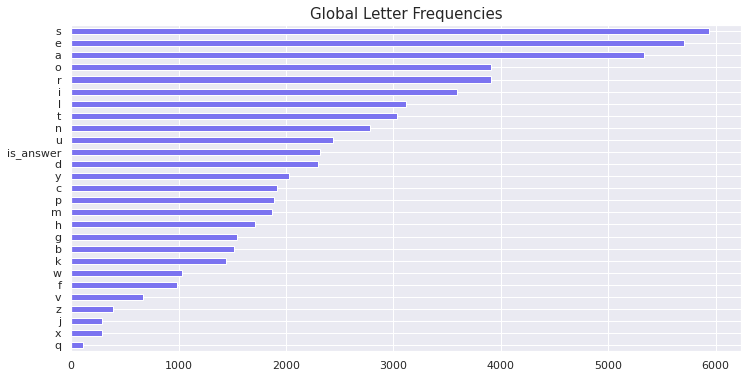

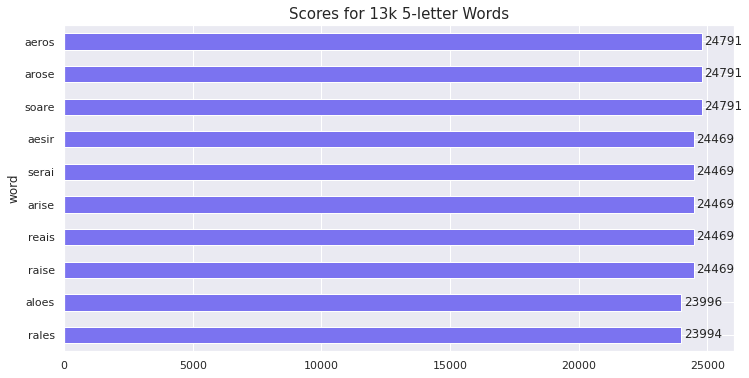

In [6]:
global_freqs = compute_letter_frequencies(wordle).sum().to_dict()
global_scores = wordle.word.apply(compute_score, freqs=global_freqs)
global_scores = pd.DataFrame({'word': wordle.word, 'score': global_scores}).sort_values('score', ascending=False)

compute_letter_frequencies(wordle).sum().sort_values().plot.barh(color=P, figsize=(12,6))
plt.title('Global Letter Frequencies', fontdict={'fontsize': 15})
plt.show()

plot_words = global_scores.head(10).reset_index(drop=True)
plot_words.set_index('word').plot.barh(color=P, figsize=(12,6), legend=None)
plt.gca().invert_yaxis()
plt.title('Scores for 13k 5-letter Words', fontdict={'fontsize': 15})
for i, row in plot_words.iterrows():
    plt.text(row.score+100, i+0.1, row.score)
plt.show()

### Single

#### FN: Global LF scorer

In [7]:
def global_lf_scorer(wordset):
    # Compute letter distribution of updated wordset
    wordset_letterdist = compute_letter_frequencies(wordset)
    freqs = wordset_letterdist.sum().to_dict()

    # Obtain scores
    scores = wordset.word.apply(compute_score, freqs=freqs)
    scores = pd.DataFrame({'word': wordset.word, 'score': scores}).sort_values('score', ascending=False)
    
    return scores

#### FN: Simulate single word

In [8]:
def sim_single(input_word, solution, score_fn, wordset=wordle):
    feedback = ''
    tested_words = []
    n_iter = 1

    while feedback != 'GGGGG':

        # Check solution
        feedback = get_feedback(input_word, solution)
        tested_words.append(input_word)
        
        # Filter wordset
        wordset = filter_wordset(input_word, feedback, wordset)
        wordset = wordset.loc[~wordset.word.isin(tested_words)]
        if n_iter == 1:
            first_cut = wordset.shape[0]
            second_cut = 0
        elif n_iter == 2:
            second_cut = wordset.shape[0]
            
        # Compute scores
        scores = score_fn(wordset)

        # Set new input word
        if scores.shape[0] > 0:
            input_word = scores.word.iloc[0]
            n_iter += 1
    return n_iter, first_cut, second_cut

#### FN: Run simulations

In [67]:
def run_sim(input_word, sim, score_fn, wordset=wordle, single=True, input_word2=None):
    
    if single:
        results = Parallel(n_jobs=5, verbose=3)(delayed(sim)(input_word, s, score_fn, wordset=wordset) for s in wordle_answers.word)
    else:
        assert input_word2 is not None
        results = Parallel(n_jobs=5, verbose=3)(delayed(sim)(input_word, input_word2, s, score_fn, wordset=wordset) for s in wordle_answers.word)
        
    data = pd.DataFrame(results, columns=['n_iter', 'first_cut', 'second_cut'])
    
    # Compute summary for no. of iterations
    summary_iter = pd.DataFrame(data.n_iter.describe()).T.reset_index(drop=True)
    summary_iter.columns = 'n_iter_' + summary_iter.columns
    summary_iter['iter_2_or_less'] = np.mean(data.n_iter <= 2)
    summary_iter['iter_3'] = np.mean(data.n_iter == 3)
    summary_iter['iter_4'] = np.mean(data.n_iter == 4)
    summary_iter['iter_5'] = np.mean(data.n_iter == 5)
    summary_iter['iter_6'] = np.mean(data.n_iter == 6)
    summary_iter['fail'] = np.mean(data.n_iter > 6)
    
    # Compute summary for first cut
    summary_c1 = pd.DataFrame(data.first_cut.describe()).T.reset_index(drop=True)
    summary_c1 = summary_c1.drop('count', axis=1)
    summary_c1.columns = 'c1_' + summary_c1.columns
    
    # Compute summary for second cut
    summary_c2 = pd.DataFrame(data.second_cut.describe()).T.reset_index(drop=True)
    summary_c2 = summary_c2.drop('count', axis=1)
    summary_c2.columns = 'c2_' + summary_c2.columns
    
    # Combine summary
    summary = pd.concat([summary_iter, summary_c1, summary_c2], axis=1)
    display(summary)
    if single:
        summary.insert(0, 'word', input_word)
        data.insert(0, 'word', input_word)
    else:
        summary.insert(0, 'words', f'{input_word}, {input_word2}')
        summary.insert(1, 'word1', input_word)
        summary.insert(2, 'word2', input_word2)
        data.insert(0, 'words', f'{input_word}, {input_word2}')
        data.insert(1, 'word1', input_word)
        data.insert(2, 'word2', input_word2)
        
    return summary, data

#### FN: Evaluate result summary

In [55]:
def eval_results(df, single=True):
    main_cols = ['n_iter_mean', 'c1_50%', 'c2_50%', 'iter_2_or_less',
               'iter_3', 'iter_4', 'iter_5', 'iter_6',
               'fail' ]
    if single:
        cols = ['word'] + main_cols
        yval = 'word'
    else:
        cols = ['words'] + main_cols
        yval = 'words'
        
    summary = df[cols].sort_values('n_iter_mean')
    display(summary)

    metrics = ['n_iter_mean', 'c1_50%', 'c2_50%']
    titles = ['Average No. of Iterations', 'Median Candidate Set Size After Iter 1', 'Median Candidate Set Size After Iter 2']
    for metric, title in zip(metrics, titles):
        plt.figure(figsize=(12, 6))
        sns.barplot(x=metric, y=yval, data=df.sort_values('n_iter_mean'), palette = [P])
        plt.title(title, fontdict={'fontsize': 15})
        # plt.xlim(4, 5)

        for i, row in df.sort_values('n_iter_mean', ascending=True).reset_index(drop=True).iterrows():
            plt.text(row[metric]+0.01, i+0.2, f"{row[metric]:.2f}")
        plt.show()

#### Get top global single words

In [11]:
glf_words_single = global_scores.groupby('score').first().sort_index(ascending=False).head(10).word.tolist()
glf_words_single += ['notes', 'resin', 'tares', 'senor']
print(glf_words_single)

['aeros', 'aesir', 'aloes', 'rales', 'stoae', 'arets', 'aisle', 'aeons', 'nears', 'saine', 'notes', 'resin', 'tares', 'senor']


#### Run global single sims

In [12]:
df_global_sgl = pd.DataFrame()
# detailed_runs = wordle_answers[['word']]
for input_word in glf_words_single:
    print('--------------------')
    print(input_word)
    print('--------------------')
    res, _ = run_sim(input_word, sim_single, global_lf_scorer)
    df_global_sgl = df_global_sgl.append(res, ignore_index=True)
    print()
    print()

--------------------
aeros
--------------------


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 201 tasks      | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done 521 tasks      | elapsed:   10.6s
[Parallel(n_jobs=5)]: Done 969 tasks      | elapsed:   20.6s
[Parallel(n_jobs=5)]: Done 1545 tasks      | elapsed:   32.7s
[Parallel(n_jobs=5)]: Done 2249 tasks      | elapsed:   48.3s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.808639,1.390831,2.0,4.0,5.0,5.0,13.0,0.011663,0.11879,...,235.0,515.0,801.0,21.422894,23.491213,0.0,5.0,12.0,30.0,119.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
aesir
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.5s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.1s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.0s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   49.8s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   50.6s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   50.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.790929,1.398976,2.0,4.0,5.0,5.0,12.0,0.012095,0.12311,...,282.0,626.0,868.0,19.782289,21.315086,0.0,5.0,13.0,26.0,111.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
aloes
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.4s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.4s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   48.9s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   49.6s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.761123,1.362369,2.0,4.0,5.0,5.0,13.0,0.009935,0.130454,...,238.0,497.0,850.0,18.151188,20.796614,0.0,4.0,11.0,23.0,213.0




--------------------
rales
--------------------


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.7s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.3s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   48.6s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   49.3s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.746004,1.325348,2.0,4.0,5.0,5.0,11.0,0.009503,0.128294,...,245.0,364.0,832.0,16.974514,17.409644,0.0,5.0,11.0,22.0,184.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
stoae
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.4s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.2s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   48.7s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   49.4s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.762419,1.37066,2.0,4.0,5.0,5.0,14.0,0.014255,0.116631,...,269.0,511.0,825.0,19.721814,19.486769,0.0,5.0,13.0,29.0,132.0




--------------------
arets
--------------------


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.1s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.4s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   32.2s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   47.4s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   48.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   48.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.683369,1.346417,2.0,4.0,4.0,5.0,12.0,0.012527,0.142981,...,241.0,487.0,940.0,17.111879,19.025821,0.0,4.0,10.0,22.0,116.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
aisle
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.2s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.5s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   32.8s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   48.3s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   48.9s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.746868,1.364392,1.0,4.0,5.0,5.0,11.0,0.013391,0.135205,...,245.0,697.0,906.0,20.059179,26.435036,0.0,4.0,11.0,26.0,247.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
aeons
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.4s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.9s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   32.9s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   47.9s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   48.6s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   48.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.758099,1.374942,2.0,4.0,4.0,5.0,12.0,0.010799,0.126134,...,273.0,525.0,861.0,18.889849,18.526102,0.0,5.0,12.0,29.0,132.0




--------------------
nears
--------------------


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.6s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.1s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.3s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   48.5s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   49.3s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.771058,1.383734,2.0,4.0,5.0,5.0,13.0,0.010799,0.133045,...,303.0,469.0,823.0,20.453132,23.710309,0.0,5.0,11.0,27.0,120.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
saine
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.2s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.4s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   32.3s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   47.2s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   47.9s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   48.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.709719,1.374375,2.0,4.0,4.0,5.0,12.0,0.015983,0.134773,...,251.0,571.0,848.0,17.207775,19.170471,0.0,4.0,10.0,24.0,160.0




--------------------
notes
--------------------


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.7s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.6s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   48.9s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.738229,1.32416,2.0,4.0,5.0,5.0,11.0,0.009071,0.134773,...,278.0,658.0,1129.0,16.961987,17.918989,0.0,5.0,11.0,23.0,220.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
resin
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.6s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.0s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.3s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   48.6s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   49.3s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.742549,1.366749,1.0,4.0,5.0,5.0,12.0,0.013391,0.128726,...,372.0,682.0,1379.0,19.090713,19.21856,0.0,5.0,13.0,25.0,111.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
tares
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.2s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.5s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   32.4s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   47.2s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   47.9s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   48.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.665227,1.32125,2.0,4.0,4.0,5.0,12.0,0.013391,0.144276,...,243.0,402.0,858.0,15.172786,14.890074,0.0,4.0,10.0,22.0,129.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
senor
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.3s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.8s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   32.7s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   47.7s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   48.4s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   48.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.739525,1.377673,2.0,4.0,5.0,5.0,12.0,0.012959,0.132613,...,308.0,570.0,1003.0,18.99568,19.13465,0.0,5.0,12.0,26.0,184.0


In [14]:
df_global_sgl.to_csv('results/global_sgl.csv', index=False)

,word,n_iter_mean,c1_50%,c2_50%,iter_2_or_less,iter_3,iter_4,iter_5,iter_6,fail
12,tares,4.665227,243.0,10.0,0.013391,0.144276,0.359395,0.269546,0.128294,0.085097
5,arets,4.683369,241.0,10.0,0.012527,0.142981,0.365443,0.259611,0.127430,0.092009
9,saine,4.709719,251.0,10.0,0.015983,0.134773,0.359395,0.269546,0.121382,0.098920
10,notes,4.738229,278.0,11.0,0.009071,0.134773,0.344708,0.285097,0.131317,0.095032
13,senor,4.739525,308.0,12.0,0.012959,0.132613,0.354212,0.273434,0.126998,0.099784
11,resin,4.742549,372.0,13.0,0.013391,0.128726,0.353780,0.274298,0.133477,0.096328
3,rales,4.746004,245.0,11.0,0.009503,0.128294,0.349460,0.282505,0.139525,0.090713
6,aisle,4.746868,245.0,11.0,0.013391,0.135205,0.340821,0.277322,0.132613,0.100648
7,aeons,4.758099,273.0,12.0,0.010799,0.126134,0.364147,0.268683,0.123974,0.106263
2,aloes,4.761123,238.0,11.0,0.009935,0.130454,0.351188,0.275594,0.129158,0.103672


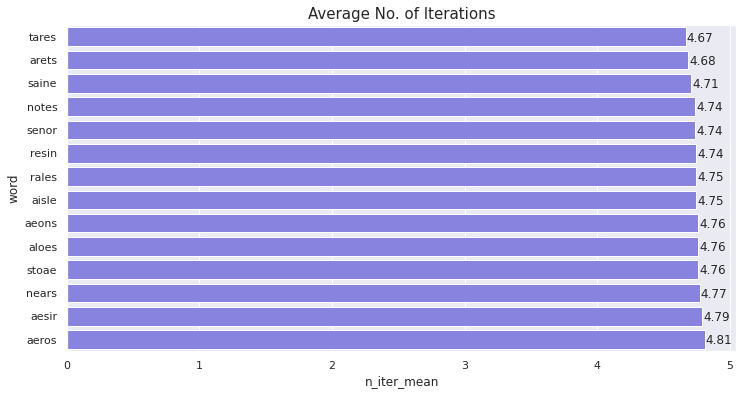

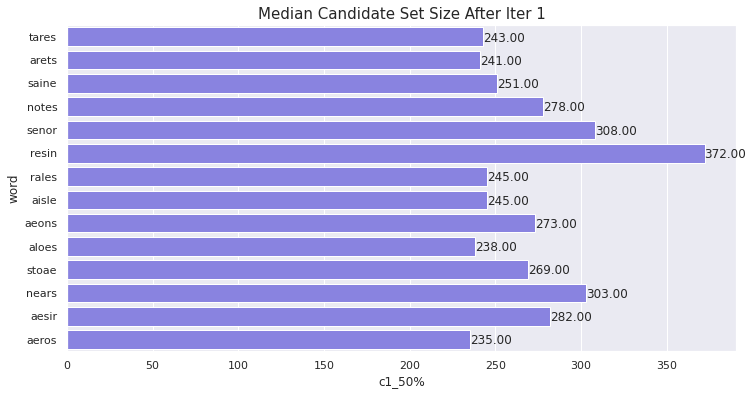

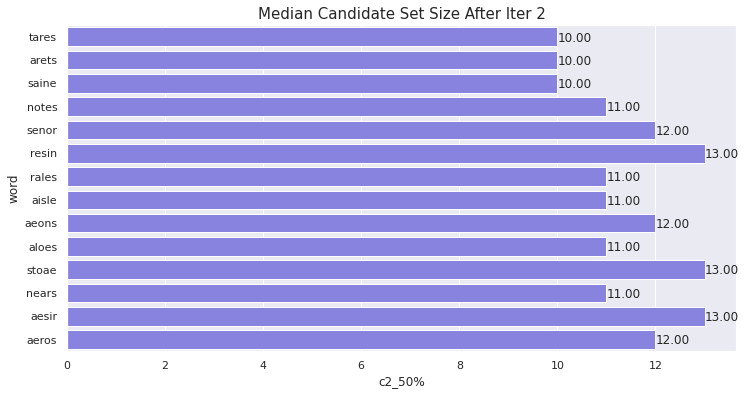

In [65]:
eval_results(df_global_sgl)

### Double

#### FN: Simulate double word strategy

In [17]:
def sim_double(input_word1, input_word2, solution, score_fn, wordset=wordle):
    feedback = ''
    tested_words = []
    n_iter = 1
    
    input_word = input_word1

    while feedback != 'GGGGG':

        # Check solution
        feedback = get_feedback(input_word, solution)
        tested_words.append(input_word)

        # Filter wordset
        wordset = filter_wordset(input_word, feedback, wordset)
        wordset = wordset.loc[~wordset.word.isin(tested_words)]
        if n_iter == 1:
            first_cut = wordset.shape[0]
            second_cut = 0
        elif n_iter == 2:
            second_cut = wordset.shape[0]

        # Compute scores
        scores = score_fn(wordset)

        # Set new input word
        if scores.shape[0] > 0:
            if len(tested_words) < 2:
                input_word = input_word2
            else:
                input_word = scores.word.iloc[0]
            n_iter += 1
    return n_iter, first_cut, second_cut

#### FN: Find second word

In [18]:
def find_second_word(word, two_vowel=True):
    letters = list(word)
    candidates = global_scores.loc[global_scores.word.apply(lambda x: all([l not in letters for l in x]))]
    candidates = candidates.loc[candidates.word.apply(lambda x: len(x) == len(set(x)))]
    if two_vowel:
        candidates = candidates.loc[
            candidates.word.apply(lambda x: x.count('a') + x.count('e') + \
                                  x.count('i') + x.count('o') + x.count('u') >= 2)
        ]
    candidates = candidates.groupby('score').first().sort_index(ascending=False)
    return candidates.head(3)

In [19]:
for input_word1 in ['tares', 'saine', 'notes', 'senor', 'resin']:
    print('----------------------------------')
    print(input_word1)
    print('----------------------------------')
    all_word2 = find_second_word(input_word1).word.tolist()
    if input_word1 == 'tares':
        all_word2 += ['chino']
    elif input_word1 == 'notes':
        all_word2 += ['acrid']
    elif input_word1 == 'senor':
        all_word2 += ['ducat']
    elif input_word1 == 'resin':
        all_word2 += ['loath']
    print(all_word2)

----------------------------------
tares
----------------------------------
['indol', 'noily', 'nicol', 'chino']
----------------------------------
saine
----------------------------------
['loury', 'yourt', 'clour']
----------------------------------
notes
----------------------------------
['urial', 'drail', 'lairy', 'acrid']
----------------------------------
senor
----------------------------------
['tidal', 'laity', 'ictal', 'ducat']
----------------------------------
resin
----------------------------------
['dotal', 'octal', 'ploat', 'loath']


#### Run double word simulations

In [20]:
df_global_dbl = pd.DataFrame()
for input_word1 in ['tares', 'saine', 'notes', 'senor', 'resin']:
    print('----------------------------------')
    print(input_word1)
    print('----------------------------------')
    all_word2 = find_second_word(input_word1).word.tolist()
    if input_word1 == 'tares':
        all_word2 += ['chino']
    elif input_word1 == 'notes':
        all_word2 += ['acrid']
    elif input_word1 == 'senor':
        all_word2 += ['ducat']
    elif input_word1 == 'resin':
        all_word2 += ['loath']
    print(all_word2)

    for input_word2 in all_word2:
        print(f'[---- {input_word1}, {input_word2} ----]')
        res, _ = run_sim(input_word1, sim_double, global_lf_scorer, single=False, input_word2=input_word2)
        df_global_dbl = df_global_dbl.append(res, ignore_index=True)

----------------------------------
tares
----------------------------------
['indol', 'noily', 'nicol', 'chino']
[---- tares, indol ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 201 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 521 tasks      | elapsed:   11.7s
[Parallel(n_jobs=5)]: Done 969 tasks      | elapsed:   21.8s
[Parallel(n_jobs=5)]: Done 1545 tasks      | elapsed:   35.7s
[Parallel(n_jobs=5)]: Done 2249 tasks      | elapsed:   54.8s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   56.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.606048,1.174991,3.0,4.0,4.0,5.0,10.0,0.0,0.139957,...,243.0,402.0,858.0,19.219006,19.277843,1.0,5.0,12.0,29.0,119.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- tares, noily ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.4s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   35.3s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   52.1s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   52.8s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   53.0s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.652268,1.224758,3.0,4.0,4.0,5.0,11.0,0.0,0.139093,...,243.0,402.0,858.0,17.409935,17.477878,1.0,5.0,11.0,23.0,134.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- tares, nicol ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.2s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   22.1s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.7s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   50.1s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   50.8s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   51.0s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.60216,1.207258,3.0,4.0,4.0,5.0,10.0,0.0,0.149892,...,243.0,402.0,858.0,17.417279,18.590372,1.0,4.0,11.0,23.0,85.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- tares, chino ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.9s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.6s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   35.0s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   52.3s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   53.0s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   53.2s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.579698,1.201779,3.0,4.0,4.0,5.0,10.0,0.0,0.167603,...,243.0,402.0,858.0,24.319654,29.756876,1.0,4.0,12.0,33.0,201.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
saine
----------------------------------
['loury', 'yourt', 'clour']
[---- saine, loury ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   13.0s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   23.3s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   38.4s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   54.8s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   55.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.806048,1.329136,3.0,4.0,5.0,5.0,12.0,0.0,0.114903,...,251.0,571.0,848.0,22.964147,22.55074,1.0,6.0,15.0,32.0,139.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- saine, yourt ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.9s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.7s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.8s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   51.1s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   51.8s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   52.0s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.7473,1.314958,3.0,4.0,4.0,5.0,13.0,0.0,0.12527,...,251.0,571.0,848.0,22.484665,23.965675,1.0,5.0,14.0,30.0,157.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- saine, clour ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   13.5s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   23.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   37.1s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   54.2s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   55.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   55.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.712311,1.275797,3.0,4.0,4.0,5.0,11.0,0.0,0.137797,...,251.0,571.0,848.0,22.338229,24.192188,1.0,5.0,12.0,35.0,157.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
notes
----------------------------------
['urial', 'drail', 'lairy', 'acrid']
[---- notes, urial ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   13.8s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   24.5s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   38.7s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   56.4s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   57.3s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   57.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.707559,1.238782,3.0,4.0,4.0,5.0,12.0,0.0,0.123542,...,278.0,658.0,1129.0,19.833693,20.517389,1.0,5.0,13.0,26.0,112.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- notes, drail ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   13.3s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   23.5s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   36.8s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   52.6s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   53.3s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   53.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.590497,1.16929,3.0,4.0,4.0,5.0,11.0,0.0,0.140389,...,278.0,658.0,1129.0,17.357235,18.095893,1.0,5.0,12.0,24.0,142.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- notes, lairy ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   13.0s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   23.7s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   37.1s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   54.3s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   55.2s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   55.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.679482,1.229881,3.0,4.0,4.0,5.0,12.0,0.0,0.129158,...,278.0,658.0,1129.0,18.320086,17.689092,1.0,5.0,13.0,25.0,134.0


[---- notes, acrid ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   13.0s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   23.6s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   37.2s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   53.9s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   54.8s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   55.0s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.614255,1.187032,2.0,4.0,4.0,5.0,11.0,0.000432,0.140389,...,278.0,658.0,1129.0,22.921382,26.312067,0.0,5.0,13.0,34.0,201.0


----------------------------------
senor
----------------------------------
['tidal', 'laity', 'ictal', 'ducat']
[---- senor, tidal ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.6s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   23.5s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   36.5s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   52.8s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   53.5s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   53.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.584881,1.184032,2.0,4.0,4.0,5.0,11.0,0.000432,0.14514,...,308.0,570.0,1003.0,20.84838,23.768709,0.0,5.0,12.0,27.0,130.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- senor, laity ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.4s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   22.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   35.4s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   51.4s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   52.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.640605,1.218374,3.0,4.0,4.0,5.0,12.0,0.0,0.133477,...,308.0,570.0,1003.0,19.283369,19.225318,1.0,5.0,12.0,27.0,121.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- senor, ictal ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.0s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   22.4s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   35.3s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   51.5s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   52.3s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   52.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.614255,1.212961,3.0,4.0,4.0,5.0,11.0,0.0,0.142549,...,308.0,570.0,1003.0,22.762851,24.240822,1.0,5.0,13.0,31.0,120.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- senor, ducat ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.7s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.9s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.8s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   49.0s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   49.7s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.579266,1.199288,3.0,4.0,4.0,5.0,11.0,0.0,0.150324,...,308.0,570.0,1003.0,27.039309,33.736302,1.0,5.0,12.0,36.0,189.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
resin
----------------------------------
['dotal', 'octal', 'ploat', 'loath']
[---- resin, dotal ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   13.1s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   22.9s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   35.8s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   51.1s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   51.8s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   52.0s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.619006,1.184742,1.0,4.0,4.0,5.0,11.0,0.000432,0.133909,...,372.0,682.0,1379.0,25.677322,29.288951,0.0,5.0,16.0,36.0,161.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- resin, octal ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.4s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   22.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.7s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   50.0s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   50.7s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   50.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.64406,1.200098,1.0,4.0,4.0,5.0,11.0,0.000864,0.126998,...,372.0,682.0,1379.0,28.15594,30.869765,0.0,5.0,16.0,40.0,180.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- resin, ploat ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.1s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.9s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.7s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   50.5s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   51.3s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   51.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.556803,1.138863,1.0,4.0,4.0,5.0,11.0,0.000432,0.142549,...,372.0,682.0,1379.0,24.978834,29.270517,0.0,4.0,12.0,36.0,153.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- resin, loath ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.8s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   22.9s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   36.3s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   53.2s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   54.2s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   54.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.629806,1.193425,1.0,4.0,4.0,5.0,11.0,0.000864,0.128726,...,372.0,682.0,1379.0,24.715335,28.222258,0.0,5.0,13.0,35.0,149.0


In [21]:
df_global_dbl.to_csv('results/global_dbl.csv', index=False)

,words,n_iter_mean,c1_50%,c2_50%,iter_2_or_less,iter_3,iter_4,iter_5,iter_6,fail
17,"resin, ploat",4.556803,372.0,12.0,0.000432,0.142549,0.408207,0.284233,0.106695,0.057883
14,"senor, ducat",4.579266,308.0,12.0,0.000000,0.150324,0.403456,0.267819,0.111015,0.067387
3,"tares, chino",4.579698,243.0,12.0,0.000000,0.167603,0.370626,0.275594,0.121382,0.064795
11,"senor, tidal",4.584881,308.0,12.0,0.000432,0.145140,0.402592,0.276890,0.107127,0.067819
8,"notes, drail",4.590497,278.0,12.0,0.000000,0.140389,0.404752,0.275594,0.116199,0.063067
2,"tares, nicol",4.602160,243.0,11.0,0.000000,0.149892,0.391793,0.274730,0.112743,0.070842
0,"tares, indol",4.606048,243.0,12.0,0.000000,0.139957,0.395680,0.286393,0.108423,0.069546
13,"senor, ictal",4.614255,308.0,13.0,0.000000,0.142549,0.396976,0.279482,0.107559,0.073434
10,"notes, acrid",4.614255,278.0,13.0,0.000432,0.140389,0.390497,0.287257,0.110583,0.070842
15,"resin, dotal",4.619006,372.0,16.0,0.000432,0.133909,0.395248,0.292441,0.109719,0.068251


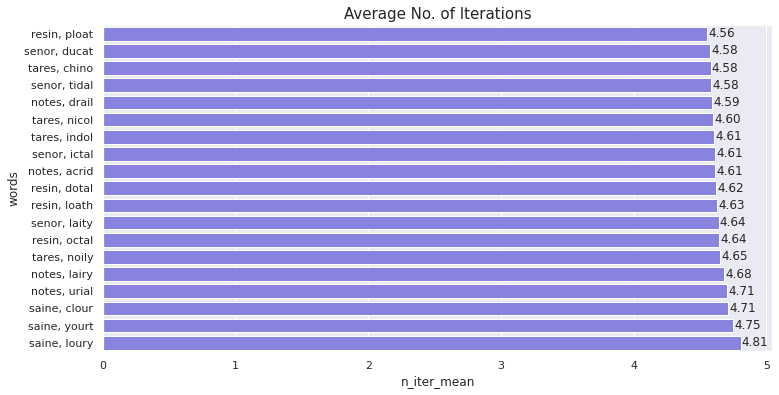

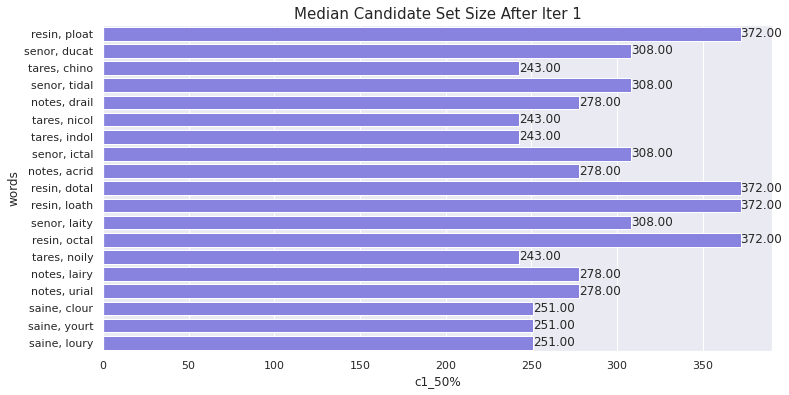

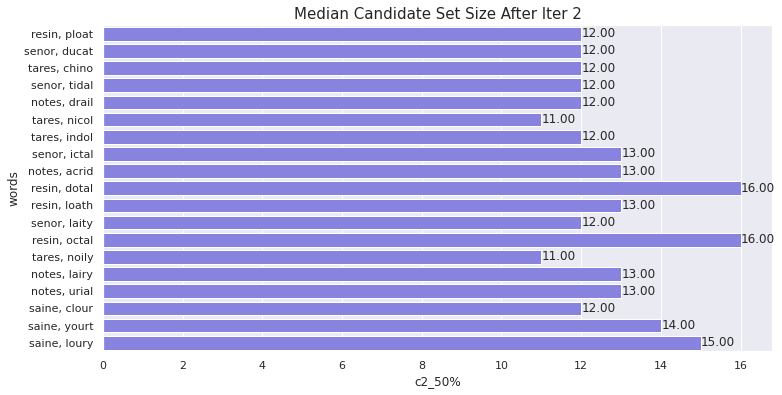

In [59]:
eval_results(df_global_dbl, single=False)

## Positional Letter Frequency

In [31]:
def compute_pos_letter_freq(wordset):
    pos_scores = {}
    pos_scores[0] = wordset.word.str[0].value_counts().to_dict()
    pos_scores[1] = wordset.word.str[1].value_counts().to_dict()
    pos_scores[2] = wordset.word.str[2].value_counts().to_dict()
    pos_scores[3] = wordset.word.str[3].value_counts().to_dict()
    pos_scores[4] = wordset.word.str[4].value_counts().to_dict()
    
    return pos_scores

In [32]:
def compute_pos_score(letters, pos_scores):
    output = 0
    for i, letter in enumerate(letters):
        output += pos_scores[i].get(letter, 0)
    return output

In [33]:
pos_scores = compute_pos_letter_freq(wordle)
pos_lf_scores = wordle.word.apply(compute_pos_score, pos_scores=pos_scores)
pos_lf_scores = pd.DataFrame({'word': wordle.word, 'score': pos_lf_scores}).sort_values('score', ascending=False)

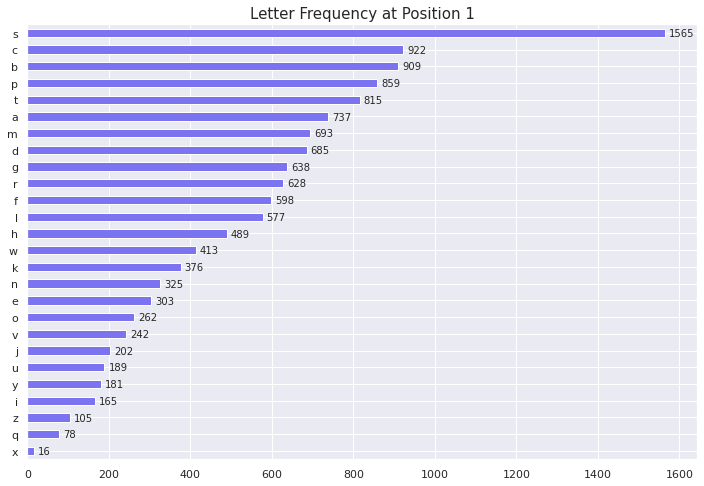

In [34]:
pos_df = pd.DataFrame(pos_scores.values()).T
pos_df[0].plot.barh(color='#7B73F0', figsize=(12,8))

for i, row in pos_df.reset_index().iterrows():
    plt.text(row[0]+10, i+0.2, row[0], fontsize=10)

plt.gca().invert_yaxis()
plt.title('Letter Frequency at Position 1', fontdict={'fontsize': 15})
plt.show()

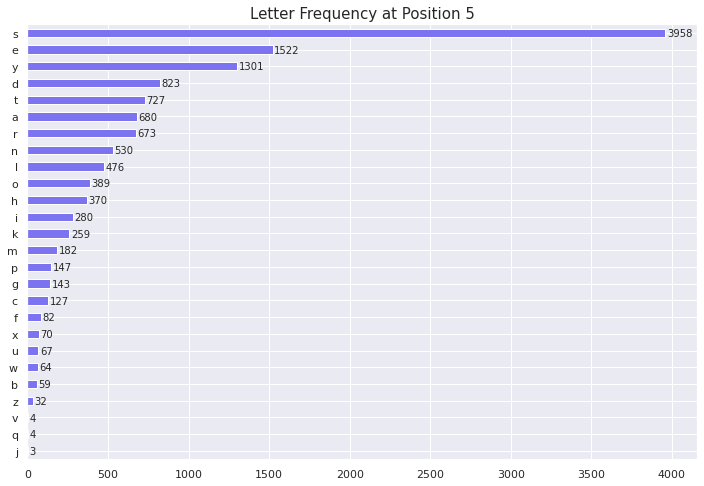

In [35]:
pos_df = pd.DataFrame(pos_scores.values()).T.sort_values(4, ascending=False)
pos_df[4].plot.barh(color='#7B73F0', figsize=(12,8))

for i, row in pos_df.reset_index().iterrows():
    plt.text(row[4]+10, i+0.2, row[4], fontsize=10)

plt.gca().invert_yaxis()
plt.title('Letter Frequency at Position 5', fontdict={'fontsize': 15})
plt.show()

### Single

#### FN: Pos LF scorer

In [38]:
def pos_lf_scorer(wordset):
    # Compute positional letter frequencies of updated wordset
    pos_scores = compute_pos_letter_freq(wordset)

    # Obtain scores
    scores = wordset.word.apply(compute_pos_score, pos_scores=pos_scores)
    scores = pd.DataFrame({'word': wordset.word, 'score': scores}).sort_values('score', ascending=False)
    scores = scores.sort_values(['score'], ascending=False)
    
    return scores

In [39]:
plf_words_single = pos_lf_scores.loc[pos_lf_scores.word.apply(lambda x: len(x) == len(set(x)))].head(10).word.tolist()
plf_words_single += ['notes', 'resin', 'senor']
print(plf_words_single)

['cares', 'bares', 'pares', 'tares', 'cores', 'bores', 'mares', 'pores', 'canes', 'dares', 'notes', 'resin', 'senor']


#### Run positional single sims

In [40]:
df_pos_sgl = pd.DataFrame()
# detailed_runs = wordle_answers[['word']]
for input_word in plf_words_single:
    print('--------------------')
    print(input_word)
    print('--------------------')
    res, _ = run_sim(input_word, sim_single, pos_lf_scorer)
    df_pos_sgl = df_pos_sgl.append(res, ignore_index=True)
    print()
    print()

--------------------
cares
--------------------


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 377 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1017 tasks      | elapsed:   10.0s
[Parallel(n_jobs=5)]: Done 1913 tasks      | elapsed:   19.0s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   23.7s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   23.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,5.02419,1.451111,2.0,4.0,5.0,6.0,12.0,0.010799,0.10108,...,284.0,453.0,901.0,33.003888,40.124218,0.0,6.0,18.0,42.0,254.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
bares
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   12.3s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   22.0s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   25.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,5.075162,1.420756,2.0,4.0,5.0,6.0,13.0,0.008207,0.096328,...,304.0,655.0,1008.0,34.321814,39.52903,0.0,7.0,20.0,43.0,253.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
pares
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1438 tasks      | elapsed:   15.9s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   25.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.974946,1.384653,2.0,4.0,5.0,6.0,12.0,0.010367,0.098488,...,297.0,475.0,972.0,30.041901,32.570626,0.0,6.5,18.0,42.5,240.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
tares
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.0s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.5s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.977106,1.407442,2.0,4.0,5.0,6.0,12.0,0.010799,0.102376,...,243.0,402.0,858.0,23.351188,27.913726,0.0,5.0,14.0,31.0,224.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
cores
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.3s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,5.010367,1.439015,2.0,4.0,5.0,6.0,12.0,0.014687,0.09892,...,347.0,477.0,1191.0,32.487257,39.520486,0.0,6.0,17.0,43.0,193.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
bores
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   11.5s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   21.7s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   25.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,5.054428,1.418964,2.0,4.0,5.0,6.0,12.0,0.009503,0.095896,...,381.0,507.0,1309.0,37.268251,42.961393,0.0,7.0,20.0,49.0,214.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
mares
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.5s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.3s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   22.8s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,5.043197,1.370715,2.0,4.0,5.0,6.0,12.0,0.007343,0.089417,...,300.0,459.0,978.0,35.001728,39.742005,0.0,7.0,19.0,48.0,229.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
pores
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   11.8s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   21.6s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   25.4s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   25.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,5.010799,1.415547,2.0,4.0,5.0,6.0,11.0,0.013391,0.09676,...,382.0,468.0,1252.0,33.932181,42.255215,0.0,7.0,17.0,45.0,228.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
canes
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 352 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 992 tasks      | elapsed:    9.7s
[Parallel(n_jobs=5)]: Done 1888 tasks      | elapsed:   19.4s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   23.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.979698,1.402869,2.0,4.0,5.0,6.0,12.0,0.008207,0.104104,...,268.0,665.0,939.0,31.37797,38.721856,0.0,7.0,17.0,40.0,273.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
dares
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   11.4s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   21.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   24.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,5.006048,1.366963,2.0,4.0,5.0,6.0,12.0,0.007343,0.092873,...,273.0,476.0,988.0,30.447948,36.428548,0.0,7.0,17.0,40.0,250.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
notes
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   11.6s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   21.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   24.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.964579,1.398712,2.0,4.0,5.0,6.0,12.0,0.014255,0.098488,...,278.0,658.0,1129.0,29.187041,36.616362,0.0,6.0,15.0,34.0,197.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
resin
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   11.8s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   21.3s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   25.2s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,5.114903,1.480416,1.0,4.0,5.0,6.0,13.0,0.009935,0.090713,...,372.0,682.0,1379.0,37.132613,47.443194,0.0,7.0,19.0,49.0,370.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
senor
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.4s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.3s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,5.0527,1.458675,2.0,4.0,5.0,6.0,12.0,0.009935,0.099784,...,308.0,570.0,1003.0,27.382289,28.375619,0.0,7.0,17.0,37.0,166.0


In [41]:
df_pos_sgl.to_csv('results/pos_sgl.csv', index=False)

,word,n_iter_mean,c1_50%,c2_50%,iter_2_or_less,iter_3,iter_4,iter_5,iter_6,fail
10,notes,4.964579,278.0,15.0,0.014255,0.098488,0.286825,0.313175,0.164579,0.122678
2,pares,4.974946,297.0,18.0,0.010367,0.098488,0.284665,0.314471,0.176674,0.115335
3,tares,4.977106,243.0,14.0,0.010799,0.102376,0.290713,0.301944,0.166307,0.127862
8,canes,4.979698,268.0,17.0,0.008207,0.104104,0.288985,0.302376,0.180130,0.116199
9,dares,5.006048,273.0,17.0,0.007343,0.092873,0.282073,0.322678,0.175810,0.119222
4,cores,5.010367,347.0,17.0,0.014687,0.098920,0.285097,0.282505,0.191361,0.127430
7,pores,5.010799,382.0,17.0,0.013391,0.096760,0.279050,0.301944,0.179266,0.129590
0,cares,5.024190,284.0,18.0,0.010799,0.101080,0.279914,0.295464,0.184449,0.128294
6,mares,5.043197,300.0,19.0,0.007343,0.089417,0.275594,0.316631,0.184017,0.126998
12,senor,5.052700,308.0,17.0,0.009935,0.099784,0.268683,0.311879,0.171490,0.138229


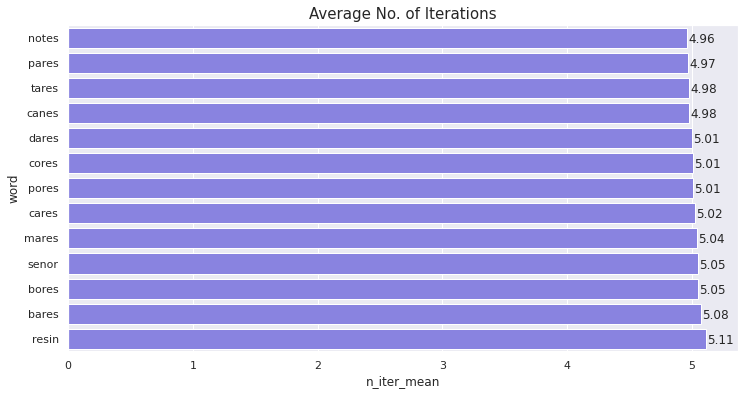

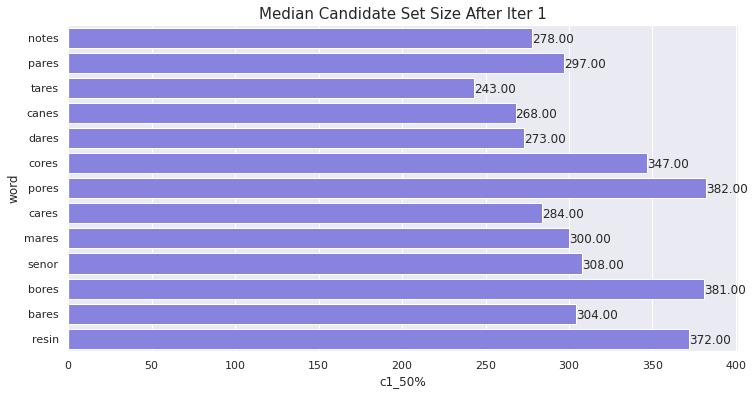

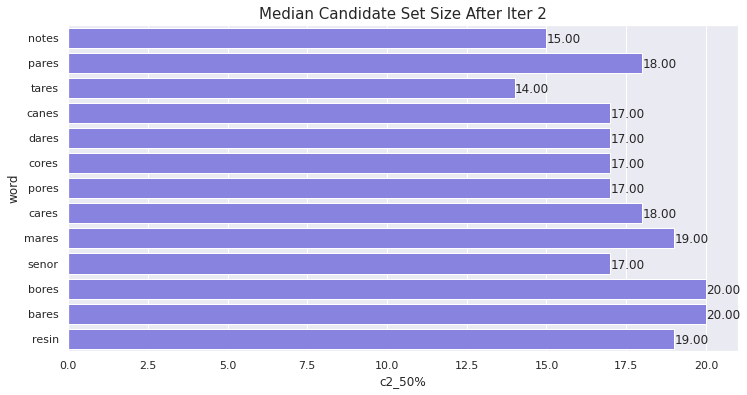

In [58]:
eval_results(df_pos_sgl, single=True)

### Double

In [52]:
def find_second_word_pos(word, two_vowel=True):
    letters = list(word)
    candidates = pos_lf_scores.loc[pos_lf_scores.word.apply(lambda x: all([l not in letters for l in x]))]
    candidates = candidates.loc[candidates.word.apply(lambda x: len(x) == len(set(x)))]
    if two_vowel:
        candidates = candidates.loc[
            candidates.word.apply(lambda x: x.count('a') + x.count('e') + \
                                  x.count('i') + x.count('o') + x.count('u') >= 2)
        ]
    candidates = candidates.groupby('score').first().sort_index(ascending=False)
    return candidates.head(4)

In [53]:
for input_word1 in ['notes', 'pares', 'tares', 'canes', 'dares', 'senor', 'resin']:
    print('----------------------------------')
    print(input_word1)
    print('----------------------------------')
    all_word2 = find_second_word_pos(input_word1).word.tolist()
    if input_word1 == 'tares':
        all_word2 += ['chino']
    elif input_word1 == 'notes':
        all_word2 += ['acrid']
    elif input_word1 == 'senor':
        all_word2 += ['ducat']
    elif input_word1 == 'resin':
        all_word2 += ['loath']
    print(all_word2)

----------------------------------
notes
----------------------------------
['daily', 'gaily', 'dairy', 'fairy', 'acrid']
----------------------------------
pares
----------------------------------
['doily', 'gouty', 'noily', 'doilt']
----------------------------------
tares
----------------------------------
['doily', 'poind', 'noily', 'piony', 'chino']
----------------------------------
canes
----------------------------------
['doily', 'roily', 'pouty', 'gouty']
----------------------------------
dares
----------------------------------
['pouty', 'gouty', 'noily', 'point']
----------------------------------
senor
----------------------------------
['laity', 'daily', 'gaily', 'haily', 'ducat']
----------------------------------
resin
----------------------------------
['coaly', 'goaty', 'coady', 'toady', 'loath']


#### Run positional two-word simulations

In [54]:
df_pos_dbl = pd.DataFrame()
for input_word1 in ['notes', 'pares', 'tares', 'canes', 'dares', 'senor', 'resin']:
    print('----------------------------------')
    print(input_word1)
    print('----------------------------------')
    all_word2 = find_second_word_pos(input_word1).word.tolist()
    if input_word1 == 'tares':
        all_word2 += ['chino']
    elif input_word1 == 'notes':
        all_word2 += ['acrid']
    elif input_word1 == 'senor':
        all_word2 += ['ducat']
    elif input_word1 == 'resin':
        all_word2 += ['loath']
    print(all_word2)

    for input_word2 in all_word2:
        print(f'[---- {input_word1}, {input_word2} ----]')
        res, _ = run_sim(input_word1, sim_double, pos_lf_scorer, single=False, input_word2=input_word2)
        df_pos_dbl = df_pos_dbl.append(res, ignore_index=True)

----------------------------------
notes
----------------------------------
['daily', 'gaily', 'dairy', 'fairy', 'acrid']
[---- notes, daily ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.3s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.806479,1.312348,2.0,4.0,5.0,5.0,11.0,0.000432,0.128726,...,278.0,658.0,1129.0,22.685961,23.815125,0.0,5.0,14.0,33.0,148.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- notes, gaily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.5s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.6s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   23.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.825054,1.316104,2.0,4.0,5.0,5.0,12.0,0.000432,0.134773,...,278.0,658.0,1129.0,25.876026,28.811306,0.0,6.0,15.0,35.0,164.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- notes, dairy ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.3s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.8s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.813823,1.354393,2.0,4.0,5.0,5.0,12.0,0.000432,0.134773,...,278.0,658.0,1129.0,21.470842,22.240346,0.0,5.0,13.0,29.0,163.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- notes, fairy ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.2s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   23.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   23.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.90324,1.38649,2.0,4.0,5.0,6.0,13.0,0.000432,0.126134,...,278.0,658.0,1129.0,26.27689,27.112043,0.0,6.0,16.0,37.0,172.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- notes, acrid ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   11.1s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   20.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   23.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.71879,1.297883,2.0,4.0,5.0,5.0,11.0,0.000432,0.146436,...,278.0,658.0,1129.0,22.921382,26.312067,0.0,5.0,13.0,34.0,201.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
pares
----------------------------------
['doily', 'gouty', 'noily', 'doilt']
[---- pares, doily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.5s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   20.0s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   23.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.795248,1.274195,3.0,4.0,5.0,5.0,11.0,0.0,0.132613,...,297.0,475.0,972.0,24.237149,25.124915,1.0,5.0,14.0,37.0,169.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- pares, gouty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.3s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.861339,1.294308,3.0,4.0,5.0,6.0,12.0,0.0,0.119222,...,297.0,475.0,972.0,32.52095,37.637215,1.0,6.0,16.0,48.0,185.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- pares, noily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.9s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.2s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.844924,1.331963,3.0,4.0,5.0,5.5,12.0,0.0,0.129158,...,297.0,475.0,972.0,22.312743,22.222159,1.0,6.0,15.0,33.0,144.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- pares, doilt ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.5s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   17.7s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   20.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.622894,1.213897,3.0,4.0,4.0,5.0,11.0,0.0,0.152916,...,297.0,475.0,972.0,18.213823,20.375231,1.0,4.0,11.0,25.0,131.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
tares
----------------------------------
['doily', 'poind', 'noily', 'piony', 'chino']
[---- tares, doily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.6s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   17.7s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   20.8s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   20.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.760259,1.302538,3.0,4.0,5.0,5.0,11.0,0.0,0.142549,...,243.0,402.0,858.0,18.552484,18.584205,1.0,5.0,12.0,24.0,154.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- tares, poind ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.3s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   17.6s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   20.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.641469,1.235183,3.0,4.0,4.0,5.0,10.0,0.0,0.15378,...,243.0,402.0,858.0,20.779266,23.859338,1.0,4.0,12.0,29.0,140.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- tares, noily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.7s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.781425,1.357046,3.0,4.0,5.0,5.0,12.0,0.0,0.145572,...,243.0,402.0,858.0,17.409935,17.477878,1.0,5.0,11.0,23.0,134.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- tares, piony ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.5s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.770626,1.323807,3.0,4.0,5.0,5.0,11.0,0.0,0.150324,...,243.0,402.0,858.0,21.96933,24.123071,1.0,5.0,12.0,32.0,137.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- tares, chino ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.0s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.2s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.735205,1.335746,3.0,4.0,5.0,5.0,11.0,0.0,0.158099,...,243.0,402.0,858.0,24.319654,29.756876,1.0,4.0,12.0,33.0,201.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
canes
----------------------------------
['doily', 'roily', 'pouty', 'gouty']
[---- canes, doily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.1s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.4s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.8s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.834125,1.343106,3.0,4.0,5.0,5.0,11.0,0.0,0.138661,...,268.0,665.0,939.0,25.422894,28.441884,1.0,5.0,14.0,38.0,170.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- canes, roily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.3s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.5s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.7s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   23.4s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   23.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.871706,1.403923,3.0,4.0,5.0,6.0,12.0,0.0,0.138229,...,268.0,665.0,939.0,20.397408,20.550383,1.0,5.0,13.0,28.0,107.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- canes, pouty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.2s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.6s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   23.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.768035,1.291625,2.0,4.0,5.0,5.0,12.0,0.000432,0.130454,...,268.0,665.0,939.0,34.514903,44.963599,0.0,6.0,17.0,47.0,194.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- canes, gouty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.5s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.8s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   23.6s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   23.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.874298,1.330518,3.0,4.0,5.0,6.0,13.0,0.0,0.120518,...,268.0,665.0,939.0,35.689849,44.992285,1.0,6.0,18.0,46.0,205.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
dares
----------------------------------
['pouty', 'gouty', 'noily', 'point']
[---- dares, pouty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.6s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   20.3s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   24.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.791793,1.267853,2.0,4.0,5.0,5.0,11.0,0.000432,0.123542,...,273.0,476.0,988.0,29.306263,34.39753,0.0,5.5,15.0,43.0,177.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- dares, gouty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   12.1s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   25.6s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   29.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.884665,1.322991,3.0,4.0,5.0,6.0,12.0,0.0,0.117927,...,273.0,476.0,988.0,30.085961,33.428389,1.0,6.0,16.0,45.0,186.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- dares, noily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   15.3s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   24.3s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   27.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.853132,1.343068,3.0,4.0,5.0,6.0,12.0,0.0,0.128726,...,273.0,476.0,988.0,21.367603,20.858541,1.0,5.5,15.0,31.0,153.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- dares, point ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.7s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   17.7s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.5s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.643629,1.248853,2.0,4.0,4.0,5.0,11.0,0.000432,0.154212,...,273.0,476.0,988.0,20.337797,24.012132,0.0,4.0,11.0,28.0,140.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
senor
----------------------------------
['laity', 'daily', 'gaily', 'haily', 'ducat']
[---- senor, laity ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.3s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   12.4s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   20.9s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   24.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   24.2s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.821166,1.364756,3.0,4.0,5.0,5.0,12.0,0.0,0.127862,...,308.0,570.0,1003.0,19.283369,19.225318,1.0,5.0,12.0,27.0,121.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- senor, daily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.6s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   17.7s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   20.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.863931,1.352378,2.0,4.0,5.0,6.0,12.0,0.000432,0.122246,...,308.0,570.0,1003.0,22.890281,22.527484,0.0,5.0,15.0,36.0,161.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- senor, gaily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.7s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.3s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.902808,1.369051,2.0,4.0,5.0,6.0,12.0,0.000432,0.129158,...,308.0,570.0,1003.0,25.359827,25.082037,0.0,6.0,16.0,41.0,158.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- senor, haily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   14.5s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   23.5s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   27.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   27.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.914903,1.3899,3.0,4.0,5.0,6.0,12.0,0.0,0.119222,...,308.0,570.0,1003.0,24.407775,24.413846,1.0,6.0,15.0,37.0,145.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- senor, ducat ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.1s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.5s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.72527,1.282026,3.0,4.0,5.0,5.0,11.0,0.0,0.136933,...,308.0,570.0,1003.0,27.039309,33.736302,1.0,5.0,12.0,36.0,189.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
resin
----------------------------------
['coaly', 'goaty', 'coady', 'toady', 'loath']
[---- resin, coaly ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.4s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.8s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   23.3s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   23.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.8946,1.386171,1.0,4.0,5.0,6.0,12.0,0.000432,0.121814,...,372.0,682.0,1379.0,27.622462,30.593044,0.0,5.0,16.0,41.0,169.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- resin, goaty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.9s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.8s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   23.5s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   23.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.888985,1.365786,1.0,4.0,5.0,6.0,12.0,0.000432,0.12527,...,372.0,682.0,1379.0,30.365011,34.564125,0.0,6.0,17.0,43.0,200.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- resin, coady ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.6s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   20.5s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   24.0s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.896328,1.343881,1.0,4.0,5.0,6.0,11.0,0.000432,0.114471,...,372.0,682.0,1379.0,34.003456,38.791957,0.0,6.0,17.0,52.0,218.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- resin, toady ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.3s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.8s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.6s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   23.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   23.0s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.842333,1.340715,1.0,4.0,5.0,6.0,11.0,0.000432,0.125702,...,372.0,682.0,1379.0,27.836285,30.672109,0.0,5.0,15.0,41.0,203.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- resin, loath ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.6s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.9s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   24.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.784017,1.327198,1.0,4.0,5.0,5.0,11.0,0.000864,0.12959,...,372.0,682.0,1379.0,24.715335,28.222258,0.0,5.0,13.0,35.0,149.0


In [56]:
df_pos_dbl.to_csv('results/pos_dbl.csv', index=False)

,words,n_iter_mean,c1_50%,c2_50%,iter_2_or_less,iter_3,iter_4,iter_5,iter_6,fail
8,"pares, doilt",4.622894,297.0,11.0,0.000000,0.152916,0.369762,0.287689,0.121382,0.068251
10,"tares, poind",4.641469,243.0,12.0,0.000000,0.153780,0.364147,0.287689,0.119654,0.074730
21,"dares, point",4.643629,273.0,11.0,0.000432,0.154212,0.366307,0.281210,0.122246,0.075594
4,"notes, acrid",4.718790,278.0,13.0,0.000432,0.146436,0.351620,0.281641,0.131317,0.088553
26,"senor, ducat",4.725270,308.0,12.0,0.000000,0.136933,0.357667,0.292441,0.123110,0.089849
13,"tares, chino",4.735205,243.0,12.0,0.000000,0.158099,0.333477,0.285097,0.123110,0.100216
9,"tares, doily",4.760259,243.0,12.0,0.000000,0.142549,0.337365,0.290713,0.132613,0.096760
16,"canes, pouty",4.768035,268.0,17.0,0.000432,0.130454,0.342981,0.304536,0.127862,0.093737
12,"tares, piony",4.770626,243.0,12.0,0.000000,0.150324,0.316631,0.304536,0.130022,0.098488
11,"tares, noily",4.781425,243.0,11.0,0.000000,0.145572,0.337365,0.281641,0.130886,0.104536


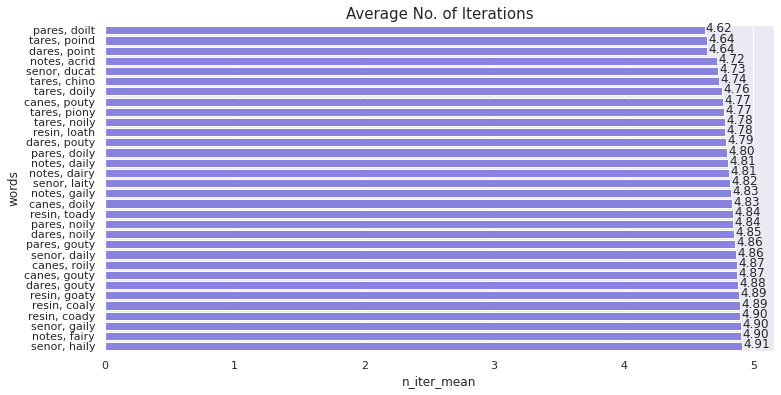

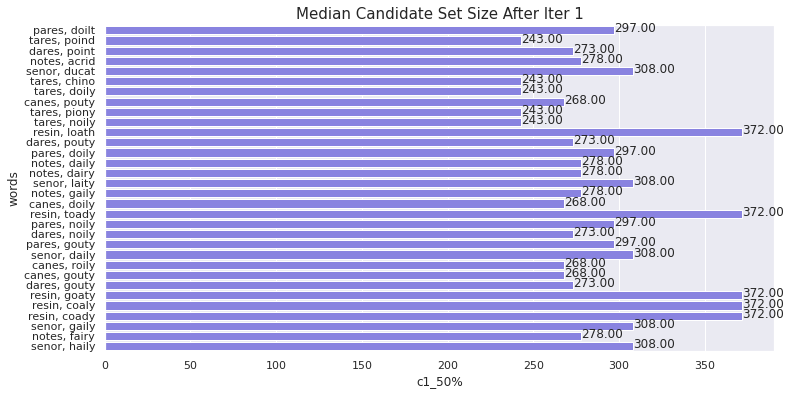

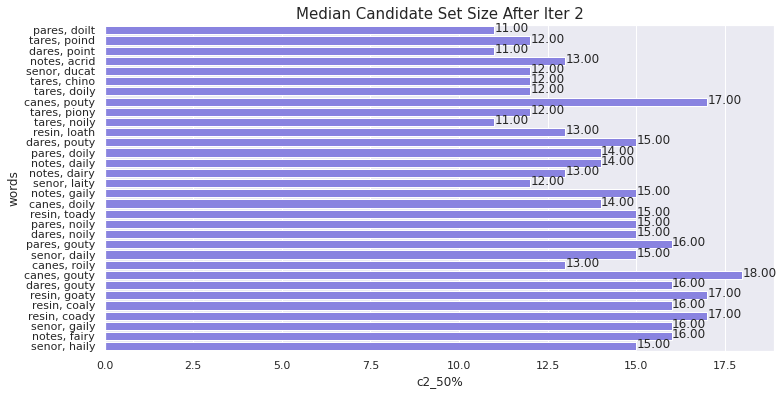

In [60]:
eval_results(df_pos_dbl, single=False)

## Word Popularity

### Popular Words

In [61]:
words_all = pd.read_table('data/archive/en_words_1_5-5.txt', delimiter=' ', header=None, index_col=None,
                         names=['word_len', 'word_freq', 'n_articles']).reset_index()
words_all = words_all.rename(columns={'index': 'word'})

# Filter by english
alphabet = list('abcdefghijklmnopqrstuvwxyz')
words_all = words_all.loc[words_all.word.apply(lambda x: all([l in alphabet for l in x]))].reset_index(drop=True)

In [62]:
# Merge additional data
wordle_pop = wordle.merge(words_all[['word', 'word_freq', 'n_articles']], how='left', left_on='word', right_on='word')
wordle_pop = wordle_pop.fillna(0)

global_scores_pop = global_scores.merge(words_all[['word', 'word_freq', 'n_articles']], how='left', left_on='word', right_on='word')
global_scores_pop = global_scores_pop.fillna(0).sort_values(['score', 'word_freq'], ascending=False)

pos_lf_scores_pop = pos_lf_scores.merge(words_all[['word', 'word_freq', 'n_articles']], how='left', left_on='word', right_on='word')
pos_lf_scores_pop = pos_lf_scores_pop.fillna(0).sort_values(['score', 'word_freq'], ascending=False)

### Global Single

In [89]:
glf_words_single_pop = global_scores_pop \
    .sort_values(['score', 'word_freq'], ascending=False) \
    .groupby('score') \
    .first() \
    .sort_index(ascending=False).head(10).word.tolist()
glf_words_single_pop += ['notes', 'resin', 'tares', 'senor']
print(glf_words_single_pop)

['arose', 'raise', 'aloes', 'laser', 'stoae', 'rates', 'aisle', 'aeons', 'snare', 'anise', 'notes', 'resin', 'tares', 'senor']


#### FN: Global LF scorer

In [64]:
def global_lf_pop_scorer(wordset):
    # Compute letter distribution of updated wordset
    wordset_letterdist = compute_letter_frequencies(wordset)
    freqs = wordset_letterdist.sum().to_dict()

    # Obtain scores
    scores = wordset.word.apply(compute_score, freqs=freqs)
    scores = pd.DataFrame({'word': wordset.word, 'score': scores, 'word_freq': wordset.word_freq}) \
        .sort_values(['score', 'word_freq'], ascending=False)
    
    return scores

#### Run global single popular word simulations

In [68]:
df_global_sgl_pop = pd.DataFrame()
# detailed_runs = wordle_answers[['word']]
for input_word in glf_words_single_pop:
    print('--------------------')
    print(input_word)
    print('--------------------')
    res, _ = run_sim(input_word, sim_single, global_lf_pop_scorer, wordset=wordle_pop)
    df_global_sgl_pop = df_global_sgl_pop.append(res, ignore_index=True)
    print()
    print()

--------------------
arose
--------------------


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 201 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 521 tasks      | elapsed:   11.1s
[Parallel(n_jobs=5)]: Done 969 tasks      | elapsed:   20.3s
[Parallel(n_jobs=5)]: Done 1545 tasks      | elapsed:   32.4s
[Parallel(n_jobs=5)]: Done 2249 tasks      | elapsed:   47.5s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.0s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.232829,1.155107,1.0,3.0,4.0,5.0,12.0,0.023326,0.232397,...,269.0,577.0,867.0,20.119222,22.50905,0.0,5.0,12.0,25.0,143.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
raise
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.5s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.9s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   32.9s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   48.4s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.191361,1.156364,1.0,3.0,4.0,5.0,11.0,0.028078,0.24838,...,233.0,449.0,882.0,17.102376,19.199502,0.0,4.0,10.0,23.0,111.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
aloes
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.5s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.9s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.2s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   50.7s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   51.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.22203,1.138217,2.0,3.0,4.0,5.0,12.0,0.018143,0.237149,...,238.0,497.0,850.0,18.981857,21.637614,0.0,5.0,12.0,25.0,213.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
laser
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.9s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   22.7s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.8s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   50.2s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   50.8s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   51.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.253564,1.141683,2.0,4.0,4.0,5.0,10.0,0.02203,0.215551,...,309.0,428.0,975.0,20.554212,22.724649,0.0,5.0,13.0,27.0,180.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
stoae
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.2s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   22.1s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.1s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   50.9s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   51.7s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   51.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.237581,1.1547,2.0,4.0,4.0,5.0,13.0,0.022894,0.222462,...,269.0,511.0,825.0,19.620302,19.496972,0.0,5.0,12.0,29.0,132.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
rates
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.9s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   22.5s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   35.8s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   51.9s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   52.7s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   52.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.168898,1.118509,2.0,3.0,4.0,5.0,11.0,0.021166,0.247084,...,244.0,402.0,858.0,15.988337,15.987634,0.0,4.0,10.0,22.0,129.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
aisle
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.8s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   23.9s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   37.4s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   54.4s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   55.2s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   55.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.221166,1.165768,1.0,3.0,4.0,5.0,10.0,0.021598,0.245788,...,245.0,697.0,906.0,17.441901,17.641133,0.0,4.0,11.0,25.0,119.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
aeons
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   13.6s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   24.1s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   37.8s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   55.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   56.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.238445,1.160495,2.0,4.0,4.0,5.0,11.0,0.018143,0.225486,...,273.0,525.0,861.0,20.139093,21.041417,0.0,5.0,12.0,31.0,132.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
snare
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.6s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   22.1s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.4s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   50.7s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   51.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.182289,1.180926,1.0,3.0,4.0,5.0,11.0,0.02851,0.247948,...,303.0,468.0,840.0,20.412959,25.771696,0.0,4.0,10.0,28.0,150.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
anise
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   13.0s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   23.7s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   37.3s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   54.0s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   55.0s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.215551,1.170703,2.0,3.0,4.0,5.0,11.0,0.025918,0.240605,...,319.0,693.0,937.0,18.955508,20.823957,0.0,5.0,11.0,26.0,138.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
notes
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   13.5s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   24.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   37.2s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   53.5s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   54.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.200432,1.125066,2.0,3.0,4.0,5.0,11.0,0.017711,0.243197,...,278.0,658.0,1129.0,17.533477,19.235004,0.0,5.0,11.0,23.0,220.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
resin
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   13.6s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   24.7s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   38.6s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   55.4s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   56.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   56.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.234557,1.155879,1.0,4.0,4.0,5.0,11.0,0.022462,0.225054,...,372.0,682.0,1379.0,19.19568,19.233164,0.0,5.0,13.0,25.0,111.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
tares
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.5s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.0s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.3s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   49.4s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   50.4s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   50.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.150756,1.102442,2.0,3.0,4.0,5.0,11.0,0.021166,0.253132,...,243.0,402.0,858.0,15.382721,15.345557,0.0,4.0,10.0,22.0,129.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
senor
--------------------


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   13.0s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   23.1s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   35.5s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   51.5s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   52.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.228078,1.178087,2.0,3.0,4.0,5.0,11.0,0.02419,0.233693,...,308.0,570.0,1003.0,20.77797,21.87481,0.0,5.0,12.0,29.0,184.0


In [69]:
df_global_sgl_pop.to_csv('results/global_sgl_pop.csv', index=False)

,word,n_iter_mean,c1_50%,c2_50%,iter_2_or_less,iter_3,iter_4,iter_5,iter_6,fail
12,tares,4.150756,243.0,10.0,0.021166,0.253132,0.426350,0.202592,0.066091,0.030670
5,rates,4.168898,244.0,10.0,0.021166,0.247084,0.427214,0.207775,0.061771,0.034989
8,snare,4.182289,303.0,10.0,0.028510,0.247948,0.410799,0.204752,0.069114,0.038877
1,raise,4.191361,233.0,10.0,0.028078,0.248380,0.396976,0.213391,0.077322,0.035853
10,notes,4.200432,278.0,11.0,0.017711,0.243197,0.424190,0.210799,0.064363,0.039741
9,anise,4.215551,319.0,11.0,0.025918,0.240605,0.406479,0.212095,0.072138,0.042765
6,aisle,4.221166,245.0,11.0,0.021598,0.245788,0.403888,0.212959,0.072570,0.043197
2,aloes,4.222030,238.0,12.0,0.018143,0.237149,0.423326,0.208207,0.074730,0.038445
13,senor,4.228078,308.0,12.0,0.024190,0.233693,0.411231,0.223326,0.067819,0.039741
0,arose,4.232829,269.0,12.0,0.023326,0.232397,0.406911,0.223758,0.076458,0.037149


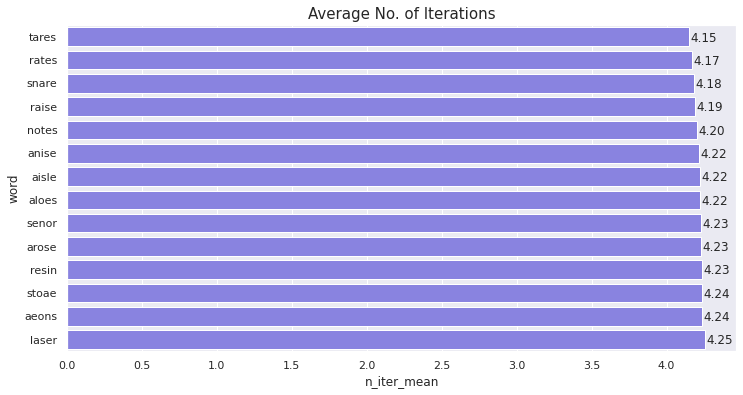

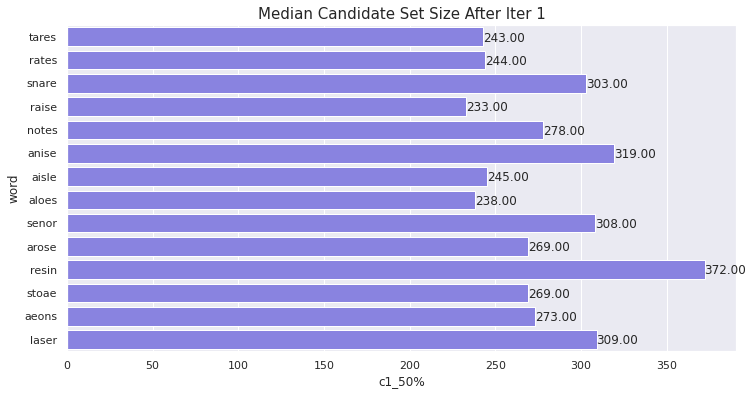

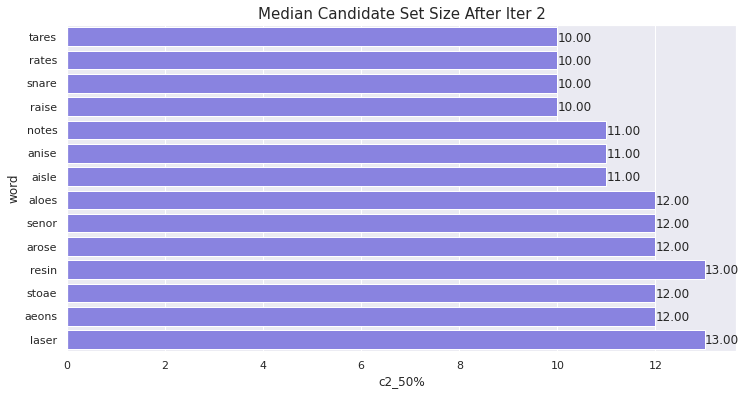

In [70]:
eval_results(df_global_sgl_pop)

### Global Double

#### FN: Find second word

In [71]:
def find_second_word_pop(word, two_vowel=True):
    letters = list(word)
    candidates = global_scores_pop.loc[global_scores_pop.word.apply(lambda x: all([l not in letters for l in x]))]
    candidates = candidates.loc[candidates.word.apply(lambda x: len(x) == len(set(x)))]
    if two_vowel:
        candidates = candidates.loc[
            candidates.word.apply(lambda x: x.count('a') + x.count('e') + \
                                  x.count('i') + x.count('o') + x.count('u') >= 2)
        ]
    candidates = candidates.groupby('score').first().sort_index(ascending=False)
    return candidates.head(3)

In [90]:
for input_word1 in glf_words_single_pop:
    print('----------------------------------')
    print(input_word1)
    print('----------------------------------')
    all_word2 = find_second_word_pop(input_word1).word.tolist()
    if input_word1 == 'tares':
        all_word2 += ['chino']
    elif input_word1 == 'notes':
        all_word2 += ['acrid']
    elif input_word1 == 'senor':
        all_word2 += ['ducat']
    elif input_word1 == 'resin':
        all_word2 += ['loath']
    print(all_word2)

----------------------------------
arose
----------------------------------
['until', 'unlid', 'culti']
----------------------------------
raise
----------------------------------
['lound', 'donut', 'clout']
----------------------------------
aloes
----------------------------------
['rutin', 'unrid', 'murti']
----------------------------------
laser
----------------------------------
['tondi', 'tonic', 'point']
----------------------------------
stoae
----------------------------------
['lurid', 'unrid', 'curli']
----------------------------------
rates
----------------------------------
['indol', 'noily', 'colin']
----------------------------------
aisle
----------------------------------
['round', 'yourt', 'court']
----------------------------------
aeons
----------------------------------
['lurid', 'curli', 'murti']
----------------------------------
snare
----------------------------------
['doilt', 'lotic', 'pilot']
----------------------------------
anise
-----------------------

#### Run double popular word simulations

In [91]:
df_global_dbl_pop = pd.DataFrame()
for input_word1 in glf_words_single_pop:
    print('----------------------------------')
    print(input_word1)
    print('----------------------------------')
    all_word2 = find_second_word_pop(input_word1).word.tolist()
    if input_word1 == 'tares':
        all_word2 += ['chino']
    elif input_word1 == 'notes':
        all_word2 += ['acrid']
    elif input_word1 == 'senor':
        all_word2 += ['ducat']
    elif input_word1 == 'resin':
        all_word2 += ['loath']
    print(all_word2)

    for input_word2 in all_word2:
        print(f'[---- {input_word1}, {input_word2} ----]')
        res, _ = run_sim(input_word1, sim_double, global_lf_pop_scorer, single=False,
                         input_word2=input_word2, wordset=wordle_pop)
        df_global_dbl_pop = df_global_dbl_pop.append(res, ignore_index=True)

----------------------------------
arose
----------------------------------
['until', 'unlid', 'culti']
[---- arose, until ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 201 tasks      | elapsed:    4.3s
[Parallel(n_jobs=5)]: Done 521 tasks      | elapsed:   10.6s
[Parallel(n_jobs=5)]: Done 969 tasks      | elapsed:   20.0s
[Parallel(n_jobs=5)]: Done 1545 tasks      | elapsed:   31.6s
[Parallel(n_jobs=5)]: Done 2249 tasks      | elapsed:   46.5s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   47.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.223758,1.093331,1.0,3.0,4.0,5.0,11.0,0.000864,0.253996,...,269.0,577.0,867.0,24.739093,28.785458,0.0,5.0,14.0,32.0,178.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- arose, unlid ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.1s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.4s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.9s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   49.6s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   50.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.249676,1.057485,1.0,4.0,4.0,5.0,10.0,0.000432,0.230238,...,269.0,577.0,867.0,30.540821,37.724888,0.0,6.0,16.0,40.0,235.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- arose, culti ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.5s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.5s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.2s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   49.7s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   50.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.192657,1.033592,1.0,4.0,4.0,5.0,11.0,0.000432,0.248812,...,269.0,577.0,867.0,26.555508,34.097042,0.0,5.0,13.0,32.0,201.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
raise
----------------------------------
['lound', 'donut', 'clout']
[---- raise, lound ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.4s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   22.8s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.7s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   49.5s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   50.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.221166,1.054841,1.0,4.0,4.0,5.0,11.0,0.000432,0.242765,...,233.0,449.0,882.0,24.439741,29.133261,0.0,5.0,13.0,30.0,203.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- raise, donut ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.8s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.5s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.5s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   49.7s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   50.4s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   50.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.156803,1.060829,1.0,3.0,4.0,5.0,10.0,0.000864,0.278618,...,233.0,449.0,882.0,23.211231,29.150844,0.0,5.0,12.0,30.0,206.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- raise, clout ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.2s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.4s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   31.9s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   46.6s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   47.3s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   47.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.128294,1.036686,1.0,3.0,4.0,5.0,11.0,0.000864,0.286393,...,233.0,449.0,882.0,22.1054,27.432216,0.0,4.0,11.0,32.0,188.0


----------------------------------
aloes
----------------------------------
['rutin', 'unrid', 'murti']
[---- aloes, rutin ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.7s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.9s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   32.9s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   47.7s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   48.5s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   48.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.193952,1.076566,3.0,3.0,4.0,5.0,11.0,0.0,0.266955,...,238.0,497.0,850.0,20.526998,21.815137,1.0,5.0,12.0,29.0,98.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- aloes, unrid ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.6s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   22.6s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   35.1s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   50.4s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   51.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.260043,1.06801,3.0,4.0,4.0,5.0,10.0,0.0,0.234125,...,238.0,497.0,850.0,25.199136,25.504225,1.0,6.0,16.0,39.0,114.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- aloes, murti ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.3s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.9s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.8s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   49.6s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   50.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.21987,1.018643,3.0,4.0,4.0,5.0,10.0,0.0,0.233693,...,238.0,497.0,850.0,24.656587,26.079908,1.0,5.0,14.0,34.0,137.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
laser
----------------------------------
['tondi', 'tonic', 'point']
[---- laser, tondi ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.0s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.8s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.2s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   49.2s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   49.9s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   50.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.182721,0.988637,3.0,4.0,4.0,5.0,10.0,0.0,0.237581,...,309.0,428.0,975.0,22.682505,23.399241,1.0,6.0,13.0,33.0,136.0


[---- laser, tonic ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.7s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.8s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   32.9s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   47.6s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   48.3s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   48.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.1473,0.991487,2.0,3.0,4.0,5.0,10.0,0.000432,0.259611,...,309.0,428.0,975.0,20.858747,21.840674,0.0,5.0,13.0,29.0,130.0


[---- laser, point ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.6s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.4s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.5s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   48.3s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   49.0s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.2s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.130886,1.025463,2.0,3.0,4.0,5.0,10.0,0.000432,0.279914,...,309.0,428.0,975.0,20.67257,22.735941,0.0,5.0,11.0,31.0,127.0


----------------------------------
stoae
----------------------------------
['lurid', 'unrid', 'curli']
[---- stoae, lurid ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.7s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.5s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   48.7s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   49.4s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.212095,1.022407,2.0,4.0,4.0,5.0,10.0,0.000432,0.237149,...,269.0,511.0,825.0,23.815551,24.901363,0.0,5.0,14.0,34.0,136.0


[---- stoae, unrid ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.6s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.1s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.3s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   49.4s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   50.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   50.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.223758,1.043168,3.0,4.0,4.0,5.0,10.0,0.0,0.235421,...,269.0,511.0,825.0,27.27689,30.050084,1.0,5.5,16.0,39.0,171.0


[---- stoae, curli ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.3s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.8s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.1s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   49.6s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   50.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.199568,1.059549,3.0,3.0,4.0,5.0,11.0,0.0,0.253996,...,269.0,511.0,825.0,24.511447,27.043296,1.0,5.0,13.0,34.0,131.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
rates
----------------------------------
['indol', 'noily', 'colin']
[---- rates, indol ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.9s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.8s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.2s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   49.0s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   49.6s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.163715,1.000206,3.0,3.0,4.0,5.0,10.0,0.0,0.2527,...,244.0,402.0,858.0,20.323974,19.451411,1.0,5.0,14.0,32.0,119.0


[---- rates, noily ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.6s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.8s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   32.7s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   49.8s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   50.5s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   50.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.190065,1.050656,3.0,3.0,4.0,5.0,10.0,0.0,0.255724,...,244.0,402.0,858.0,17.985313,17.175734,1.0,5.0,13.0,26.0,134.0


[---- rates, colin ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.8s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   23.6s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   37.2s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   54.4s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   55.0s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   55.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.115335,1.00134,3.0,3.0,4.0,5.0,10.0,0.0,0.279482,...,244.0,402.0,858.0,16.890713,17.919142,1.0,4.0,11.0,23.0,80.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
aisle
----------------------------------
['round', 'yourt', 'court']
[---- aisle, round ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   13.4s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   25.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   39.5s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   56.8s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   58.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   58.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.261771,1.073642,1.0,4.0,4.0,5.0,10.0,0.000864,0.230238,...,245.0,697.0,906.0,29.080778,36.652624,0.0,5.0,15.0,37.0,208.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- aisle, yourt ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   13.1s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   23.0s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   36.9s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   54.3s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   55.2s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   55.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.266955,1.111545,1.0,4.0,4.0,5.0,11.0,0.000432,0.23067,...,245.0,697.0,906.0,25.946004,30.840938,0.0,6.0,15.0,35.0,212.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- aisle, court ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   13.7s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   23.6s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   35.5s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   51.8s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   52.7s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   52.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.158963,1.061526,1.0,3.0,4.0,5.0,11.0,0.000864,0.267819,...,245.0,697.0,906.0,23.942117,32.364165,0.0,4.0,12.0,27.0,192.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
aeons
----------------------------------
['lurid', 'curli', 'murti']
[---- aeons, lurid ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.1s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   22.4s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   36.1s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   53.6s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   54.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.248812,1.054415,2.0,4.0,4.0,5.0,10.0,0.000432,0.228078,...,273.0,525.0,861.0,25.109719,26.953288,0.0,6.0,15.0,37.0,119.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- aeons, curli ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   13.4s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   24.5s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   38.7s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   55.7s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   56.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.27689,1.076887,3.0,4.0,4.0,5.0,11.0,0.0,0.225486,...,273.0,525.0,861.0,24.337365,26.437509,1.0,6.0,14.0,34.0,123.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- aeons, murti ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   14.0s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   25.1s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   38.6s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   55.5s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   56.3s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   56.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.239741,1.018825,3.0,4.0,4.0,5.0,10.0,0.0,0.219006,...,273.0,525.0,861.0,28.765875,32.64364,1.0,6.0,16.0,41.0,175.0


----------------------------------
snare
----------------------------------
['doilt', 'lotic', 'pilot']
[---- snare, doilt ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.5s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   22.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.4s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   50.7s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   51.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.08121,1.02786,1.0,3.0,4.0,5.0,10.0,0.000432,0.301944,...,303.0,468.0,840.0,17.664795,21.532391,0.0,4.0,10.0,23.0,160.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- snare, lotic ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.2s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   22.8s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.6s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   49.2s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   49.8s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   50.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.142549,1.0557,1.0,3.0,4.0,5.0,10.0,0.000432,0.282073,...,303.0,468.0,840.0,19.692873,23.927944,0.0,5.0,11.0,25.0,144.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- snare, pilot ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.0s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.9s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.1s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   49.2s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   50.0s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   50.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.110151,1.04582,1.0,3.0,4.0,5.0,10.0,0.000864,0.288553,...,303.0,468.0,840.0,19.743413,24.631069,0.0,4.0,10.0,25.0,141.0


----------------------------------
anise
----------------------------------
['loury', 'yourt', 'clour']
[---- anise, loury ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.9s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.7s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.6s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   50.9s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   51.6s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   51.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.301512,1.118236,3.0,4.0,4.0,5.0,11.0,0.0,0.225918,...,319.0,693.0,937.0,28.516199,34.061096,1.0,6.0,16.0,37.0,213.0


[---- anise, yourt ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   13.5s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   24.0s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   36.9s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   52.5s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   53.2s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   53.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.266955,1.127756,3.0,4.0,4.0,5.0,11.0,0.0,0.241469,...,319.0,693.0,937.0,28.405184,36.016586,1.0,5.0,15.0,36.0,238.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- anise, clour ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.0s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   22.4s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   35.3s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   51.7s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   52.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.21987,1.062255,3.0,3.0,4.0,5.0,11.0,0.0,0.255724,...,319.0,693.0,937.0,28.000864,35.15335,1.0,5.0,13.0,38.0,216.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
notes
----------------------------------
['urali', 'laird', 'riyal', 'acrid']
[---- notes, urali ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.8s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   23.3s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   36.3s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   51.8s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   52.5s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   52.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.256587,1.073284,3.0,4.0,4.0,5.0,11.0,0.0,0.23067,...,278.0,658.0,1129.0,19.32527,18.897966,1.0,6.0,14.0,25.0,105.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- notes, laird ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.9s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.9s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   35.0s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   51.0s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   52.0s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.152052,1.024859,3.0,3.0,4.0,5.0,10.0,0.0,0.267387,...,278.0,658.0,1129.0,17.494168,17.192925,1.0,5.0,12.0,24.0,119.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- notes, riyal ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.1s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.5s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.6s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   49.0s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   49.7s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.210799,1.037984,3.0,4.0,4.0,5.0,10.0,0.0,0.247516,...,278.0,658.0,1129.0,19.665659,18.853908,1.0,5.0,13.0,26.0,134.0


[---- notes, acrid ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.9s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.4s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.4s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   48.7s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.177106,1.022941,2.0,3.0,4.0,5.0,10.0,0.000432,0.25054,...,278.0,658.0,1129.0,22.921382,26.312067,0.0,5.0,13.0,34.0,201.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
resin
----------------------------------
['dotal', 'octal', 'ploat', 'loath']
[---- resin, dotal ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.8s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.2s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   48.5s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   49.2s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.165443,1.001217,1.0,3.0,4.0,5.0,10.0,0.000432,0.257019,...,372.0,682.0,1379.0,25.677322,29.288951,0.0,5.0,16.0,36.0,161.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- resin, octal ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   12.6s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   22.3s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   35.8s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   52.1s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   52.8s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   53.0s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.187041,1.012457,1.0,4.0,4.0,5.0,10.0,0.000864,0.245788,...,372.0,682.0,1379.0,28.15594,30.869765,0.0,5.0,16.0,40.0,180.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- resin, ploat ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.6s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.7s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   49.5s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   50.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   50.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.137797,0.99763,1.0,3.0,4.0,5.0,11.0,0.000432,0.266091,...,372.0,682.0,1379.0,24.978834,29.270517,0.0,4.0,12.0,36.0,153.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- resin, loath ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.9s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.5s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   48.4s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   49.2s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.185745,1.021829,1.0,3.0,4.0,5.0,10.0,0.000864,0.251836,...,372.0,682.0,1379.0,24.715335,28.222258,0.0,5.0,13.0,35.0,149.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
tares
----------------------------------
['indol', 'noily', 'colin', 'chino']
[---- tares, indol ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.3s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   34.0s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   48.7s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   49.4s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   49.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.145572,0.994788,3.0,3.0,4.0,5.0,10.0,0.0,0.261339,...,243.0,402.0,858.0,19.219006,19.277843,1.0,5.0,12.0,29.0,119.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- tares, noily ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.0s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.0s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   31.4s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   45.8s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   46.4s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   46.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.166307,1.038784,3.0,3.0,4.0,5.0,10.0,0.0,0.265659,...,243.0,402.0,858.0,17.409935,17.477878,1.0,5.0,11.0,23.0,134.0


[---- tares, colin ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.9s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.8s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   32.6s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   46.5s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   47.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   47.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.093737,0.999278,3.0,3.0,4.0,5.0,10.0,0.0,0.292441,...,243.0,402.0,858.0,16.188337,17.826663,1.0,4.0,10.0,20.5,81.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- tares, chino ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.2s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.3s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   32.6s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   47.9s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   48.5s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   48.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.123542,1.012597,3.0,3.0,4.0,5.0,10.0,0.0,0.287689,...,243.0,402.0,858.0,24.319654,29.756876,1.0,4.0,12.0,33.0,201.0


----------------------------------
senor
----------------------------------
['tidal', 'laity', 'tical', 'ducat']
[---- senor, tidal ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.5s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   21.6s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   33.6s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   48.0s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   48.7s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   48.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.117063,1.014433,2.0,3.0,4.0,5.0,10.0,0.000432,0.278186,...,308.0,570.0,1003.0,20.84838,23.768709,0.0,5.0,12.0,27.0,130.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- senor, laity ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.3s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.4s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   31.6s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   45.9s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   46.6s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   46.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.17149,1.044994,3.0,3.0,4.0,5.0,11.0,0.0,0.259611,...,308.0,570.0,1003.0,19.283369,19.225318,1.0,5.0,12.0,27.0,121.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- senor, tical ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.0s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   19.9s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   31.0s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   45.1s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   45.8s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   45.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.0946,0.991817,3.0,3.0,4.0,5.0,10.0,0.0,0.282937,...,308.0,570.0,1003.0,20.626782,23.936584,1.0,5.0,11.0,25.0,120.0


[---- senor, ducat ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:   11.3s
[Parallel(n_jobs=5)]: Done 994 tasks      | elapsed:   20.2s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:   31.7s
[Parallel(n_jobs=5)]: Done 2274 tasks      | elapsed:   45.9s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   46.6s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   46.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.138661,1.016818,3.0,3.0,4.0,5.0,11.0,0.0,0.266523,...,308.0,570.0,1003.0,27.039309,33.736302,1.0,5.0,12.0,36.0,189.0


In [92]:
df_global_dbl_pop.to_csv('results/global_dbl_pop.csv', index=False)

,words,n_iter_mean,c1_50%,c2_50%,iter_2_or_less,iter_3,iter_4,iter_5,iter_6,fail
24,"snare, doilt",4.081210,303.0,10.0,0.000432,0.301944,0.433693,0.186177,0.052268,0.025486
40,"tares, colin",4.093737,243.0,10.0,0.000000,0.292441,0.435421,0.192225,0.057883,0.022030
44,"senor, tical",4.094600,308.0,11.0,0.000000,0.282937,0.452268,0.188769,0.051404,0.024622
26,"snare, pilot",4.110151,303.0,10.0,0.000864,0.288553,0.441901,0.187041,0.047516,0.034125
17,"rates, colin",4.115335,244.0,11.0,0.000000,0.279482,0.443629,0.193952,0.060475,0.022462
42,"senor, tidal",4.117063,308.0,12.0,0.000432,0.278186,0.444060,0.200864,0.050540,0.025918
41,"tares, chino",4.123542,243.0,12.0,0.000000,0.287689,0.418575,0.212527,0.057883,0.023326
5,"raise, clout",4.128294,233.0,11.0,0.000864,0.286393,0.421166,0.207775,0.057019,0.026782
11,"laser, point",4.130886,309.0,11.0,0.000432,0.279914,0.432829,0.205184,0.052700,0.028942
36,"resin, ploat",4.137797,372.0,12.0,0.000432,0.266091,0.443629,0.209935,0.057451,0.022462


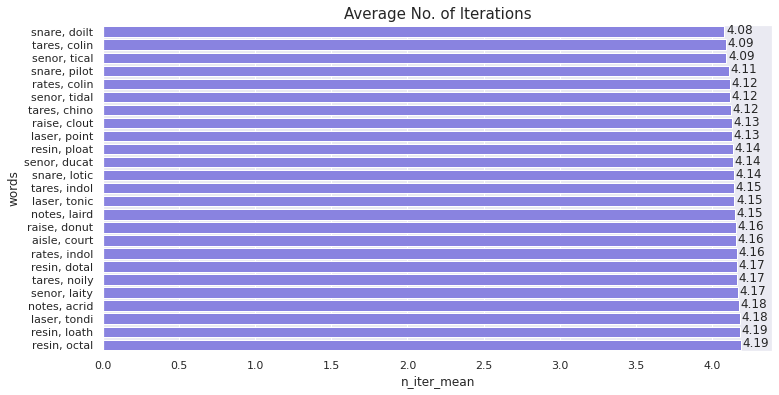

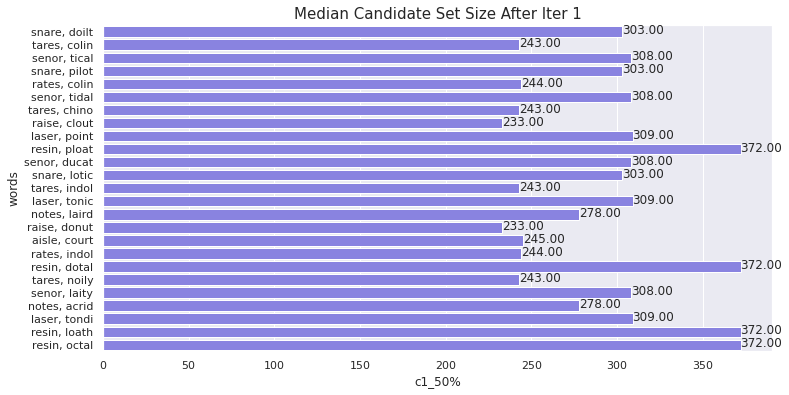

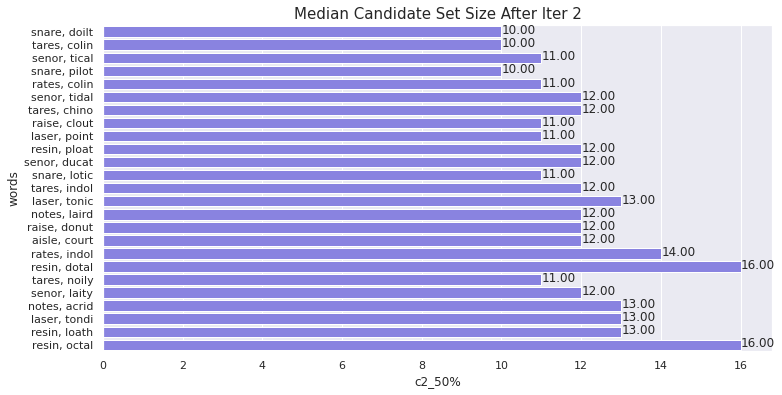

In [94]:
eval_results(df_global_dbl_pop.sort_values('n_iter_mean').iloc[:25], single=False)

### Positional Single

#### FN: Pos LF scorer

In [76]:
def pos_lf_pop_scorer(wordset):
    # Compute positional letter frequencies of updated wordset
    pos_scores = compute_pos_letter_freq(wordset)

    # Obtain scores
    scores = wordset.word.apply(compute_pos_score, pos_scores=pos_scores)
    scores = pd.DataFrame({'word': wordset.word, 'score': scores, 'word_freq': wordset.word_freq}) \
        .sort_values(['score', 'word_freq'], ascending=False)
    
    return scores

In [77]:
plf_words_single_pop = pos_lf_scores_pop.loc[pos_lf_scores_pop.word.apply(lambda x: len(x) == len(set(x)))].head(10).word.tolist()
plf_words_single_pop += ['notes', 'resin', 'senor']
print(plf_words_single_pop)

['cares', 'bares', 'pares', 'tares', 'cores', 'bores', 'mares', 'pores', 'canes', 'dares', 'notes', 'resin', 'senor']


#### Run positional single sims

In [78]:
df_pos_sgl_pop = pd.DataFrame()
# detailed_runs = wordle_answers[['word']]
for input_word in plf_words_single_pop:
    print('--------------------')
    print(input_word)
    print('--------------------')
    res, _ = run_sim(input_word, sim_single, pos_lf_pop_scorer, wordset=wordle_pop)
    df_pos_sgl_pop = df_pos_sgl_pop.append(res, ignore_index=True)
    print()
    print()

--------------------
cares
--------------------


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 377 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1017 tasks      | elapsed:    9.3s
[Parallel(n_jobs=5)]: Done 1913 tasks      | elapsed:   17.3s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   20.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.290713,1.065153,2.0,4.0,4.0,5.0,11.0,0.019006,0.190497,...,284.0,453.0,901.0,31.263067,37.677639,0.0,6.0,17.0,39.0,254.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
bares
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.3s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.6s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   22.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.327862,1.054716,2.0,4.0,4.0,5.0,11.0,0.017711,0.178834,...,304.0,655.0,1008.0,34.303672,39.546399,0.0,8.0,21.0,43.0,253.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
pares
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.0s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.1s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.4s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.264795,1.019829,2.0,4.0,4.0,5.0,10.0,0.017279,0.2,...,297.0,475.0,972.0,30.102808,32.497494,0.0,7.0,18.0,42.0,240.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
tares
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.6s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   17.5s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   20.7s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   20.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.231533,1.041054,2.0,4.0,4.0,5.0,10.0,0.018575,0.212527,...,243.0,402.0,858.0,23.317927,27.930817,0.0,5.0,14.0,30.5,224.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
cores
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.1s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.4s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.7s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.27041,1.054833,2.0,4.0,4.0,5.0,11.0,0.020302,0.191793,...,347.0,477.0,1191.0,32.394816,39.535205,0.0,6.0,17.0,43.0,193.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
bores
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.4s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.9s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   22.4s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.339957,1.069223,2.0,4.0,4.0,5.0,11.0,0.015119,0.183153,...,381.0,507.0,1309.0,37.266523,42.964522,0.0,7.0,20.0,49.0,214.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
mares
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.3s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.7s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   22.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.331749,1.016973,2.0,4.0,4.0,5.0,10.0,0.012527,0.178402,...,300.0,459.0,978.0,34.972786,39.769351,0.0,7.0,19.0,48.0,229.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
pores
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.2s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.7s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.292009,1.050703,2.0,4.0,4.0,5.0,10.0,0.018575,0.192225,...,382.0,468.0,1252.0,33.83067,42.289908,0.0,7.0,17.0,43.0,228.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
canes
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.0s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.3s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.278186,1.018169,2.0,4.0,4.0,5.0,10.0,0.015551,0.187473,...,268.0,665.0,939.0,31.304536,38.777395,0.0,7.0,17.0,40.0,273.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
dares
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.1s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.4s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.7s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.292009,1.032866,2.0,4.0,4.0,5.0,10.0,0.013823,0.190929,...,273.0,476.0,988.0,29.436717,33.898939,0.0,7.0,17.0,42.0,250.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
notes
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.0s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.3s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.239309,1.023793,2.0,4.0,4.0,5.0,10.0,0.018143,0.20432,...,278.0,658.0,1129.0,29.178834,36.622062,0.0,6.0,15.0,34.0,197.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
resin
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.2s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.9s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   22.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.361123,1.062868,1.0,4.0,4.0,5.0,11.0,0.016415,0.172786,...,372.0,682.0,1379.0,37.198704,47.425029,0.0,7.0,19.0,49.0,370.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.




--------------------
senor
--------------------


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.7s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   17.8s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.0s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.321382,1.088339,2.0,4.0,4.0,5.0,11.0,0.017711,0.185745,...,308.0,570.0,1003.0,27.299784,28.432713,0.0,6.0,17.0,37.0,166.0


In [79]:
df_pos_sgl_pop.to_csv('results/pos_sgl_pop.csv', index=False)

,word,n_iter_mean,c1_50%,c2_50%,iter_2_or_less,iter_3,iter_4,iter_5,iter_6,fail
3,tares,4.231533,243.0,14.0,0.018575,0.212527,0.424622,0.242333,0.076458,0.025486
10,notes,4.239309,278.0,15.0,0.018143,0.204320,0.427214,0.254860,0.069546,0.025918
2,pares,4.264795,297.0,18.0,0.017279,0.200000,0.413391,0.269114,0.078186,0.022030
4,cores,4.270410,347.0,17.0,0.020302,0.191793,0.431533,0.251836,0.075162,0.029374
8,canes,4.278186,268.0,17.0,0.015551,0.187473,0.431533,0.271274,0.069114,0.025054
0,cares,4.290713,284.0,17.0,0.019006,0.190497,0.423326,0.258315,0.079914,0.028942
7,pores,4.292009,382.0,17.0,0.018575,0.192225,0.417279,0.261339,0.081210,0.029374
9,dares,4.292009,273.0,17.0,0.013823,0.190929,0.430670,0.255292,0.083369,0.025918
12,senor,4.321382,308.0,17.0,0.017711,0.185745,0.426350,0.249244,0.083369,0.037581
1,bares,4.327862,304.0,21.0,0.017711,0.178834,0.417279,0.272138,0.083801,0.030238


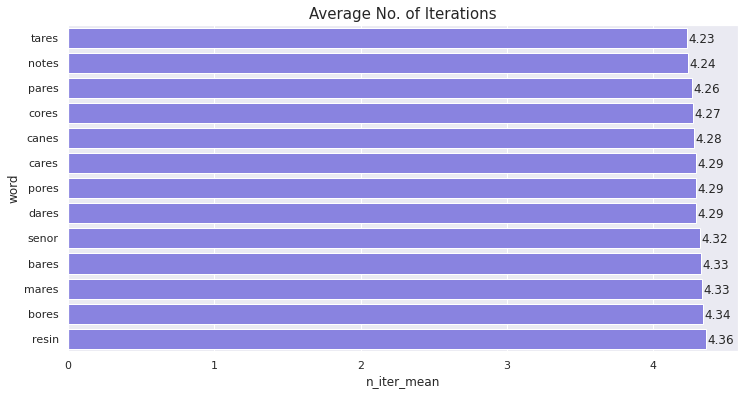

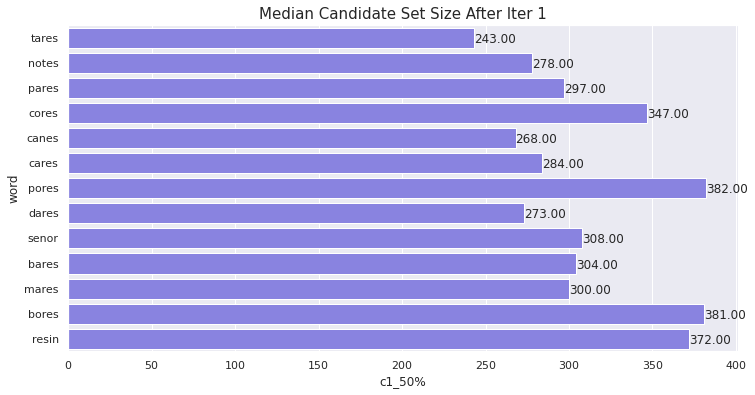

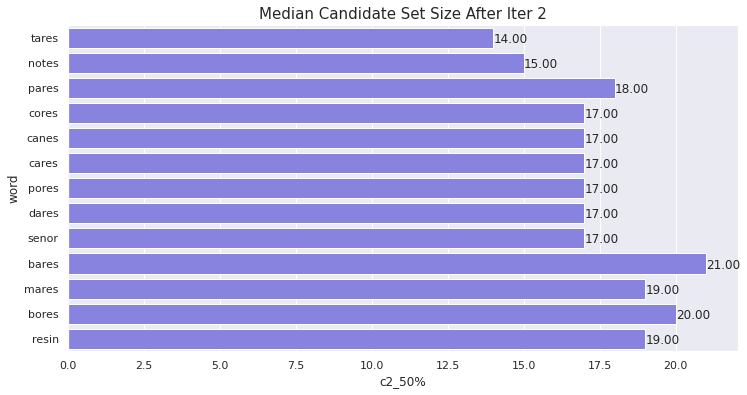

In [80]:
eval_results(df_pos_sgl_pop, single=True)

### Positional Double

In [82]:
def find_second_word_pos_pop(word, two_vowel=True):
    letters = list(word)
    candidates = pos_lf_scores_pop.loc[pos_lf_scores_pop.word.apply(lambda x: all([l not in letters for l in x]))]
    candidates = candidates.loc[candidates.word.apply(lambda x: len(x) == len(set(x)))]
    if two_vowel:
        candidates = candidates.loc[
            candidates.word.apply(lambda x: x.count('a') + x.count('e') + \
                                  x.count('i') + x.count('o') + x.count('u') >= 2)
        ]
    candidates = candidates.groupby('score').first().sort_index(ascending=False)
    return candidates.head(4)

In [83]:
for input_word1 in plf_words_single_pop:
    print('----------------------------------')
    print(input_word1)
    print('----------------------------------')
    all_word2 = find_second_word_pos(input_word1).word.tolist()
    if input_word1 == 'tares':
        all_word2 += ['chino']
    elif input_word1 == 'notes':
        all_word2 += ['acrid']
    elif input_word1 == 'senor':
        all_word2 += ['ducat']
    elif input_word1 == 'resin':
        all_word2 += ['loath']
    print(all_word2)

----------------------------------
cares
----------------------------------
['doily', 'pouty', 'poind', 'gouty']
----------------------------------
bares
----------------------------------
['doily', 'pouty', 'poind', 'gouty']
----------------------------------
pares
----------------------------------
['doily', 'gouty', 'noily', 'doilt']
----------------------------------
tares
----------------------------------
['doily', 'poind', 'noily', 'piony', 'chino']
----------------------------------
cores
----------------------------------
['laity', 'daily', 'gaily', 'haily']
----------------------------------
bores
----------------------------------
['laity', 'daily', 'gaily', 'haily']
----------------------------------
mares
----------------------------------
['doily', 'pouty', 'poind', 'gouty']
----------------------------------
pores
----------------------------------
['laity', 'daily', 'gaily', 'haily']
----------------------------------
canes
----------------------------------
['doily', '

#### Run positional two-word simulations

In [85]:
df_pos_dbl_pop = pd.DataFrame()
for input_word1 in plf_words_single_pop:
    print('----------------------------------')
    print(input_word1)
    print('----------------------------------')
    all_word2 = find_second_word_pos(input_word1).word.tolist()
    if input_word1 == 'tares':
        all_word2 += ['chino']
    elif input_word1 == 'notes':
        all_word2 += ['acrid']
    elif input_word1 == 'senor':
        all_word2 += ['ducat']
    elif input_word1 == 'resin':
        all_word2 += ['loath']
    print(all_word2)

    for input_word2 in all_word2:
        print(f'[---- {input_word1}, {input_word2} ----]')
        res, _ = run_sim(input_word1, sim_double, pos_lf_pop_scorer,
                         single=False, input_word2=input_word2, wordset=wordle_pop)
        df_pos_dbl_pop = df_pos_dbl_pop.append(res, ignore_index=True)

----------------------------------
cares
----------------------------------
['doily', 'pouty', 'poind', 'gouty']
[---- cares, doily ----]


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 377 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 1017 tasks      | elapsed:    8.9s
[Parallel(n_jobs=5)]: Done 1913 tasks      | elapsed:   16.5s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   20.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   20.2s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.172786,0.976138,3.0,3.0,4.0,5.0,10.0,0.0,0.250972,...,284.0,453.0,901.0,21.650108,22.289082,1.0,5.0,13.0,30.0,169.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- cares, pouty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.6s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   17.7s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   20.8s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   20.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.189633,0.951674,2.0,4.0,4.0,5.0,9.0,0.000432,0.234125,...,284.0,453.0,901.0,29.555508,36.09497,0.0,5.0,14.0,42.0,178.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- cares, poind ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.3s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.3s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.6s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.151188,0.944228,3.0,3.0,4.0,5.0,9.0,0.0,0.2527,...,284.0,453.0,901.0,24.314039,28.626395,1.0,4.5,13.0,34.0,129.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- cares, gouty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.8s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.2s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.5s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.242333,0.97971,3.0,4.0,4.0,5.0,10.0,0.0,0.220302,...,284.0,453.0,901.0,29.12743,33.674284,1.0,6.0,15.0,40.0,181.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
bares
----------------------------------
['doily', 'pouty', 'poind', 'gouty']
[---- bares, doily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.3s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.4s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.7s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   22.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.2s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.225054,0.971893,3.0,4.0,4.0,5.0,10.0,0.0,0.229806,...,304.0,655.0,1008.0,26.12959,26.069178,1.0,6.0,16.0,43.0,175.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- bares, pouty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.3s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.9s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   20.1s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   23.7s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   23.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.240605,0.951045,2.0,4.0,4.0,5.0,9.0,0.000432,0.212959,...,304.0,655.0,1008.0,33.234989,38.704207,0.0,6.0,16.0,50.0,170.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- bares, poind ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.3s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.8s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.3s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.195248,0.937029,3.0,4.0,4.0,5.0,10.0,0.0,0.23067,...,304.0,655.0,1008.0,27.834557,31.156182,1.0,5.5,17.0,37.0,156.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- bares, gouty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.5s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.8s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   22.3s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.292873,0.996414,3.0,4.0,4.0,5.0,10.0,0.0,0.206479,...,304.0,655.0,1008.0,34.546436,38.314013,1.0,7.0,18.0,55.0,167.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
pares
----------------------------------
['doily', 'gouty', 'noily', 'doilt']
[---- pares, doily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.6s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.2s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   22.7s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.188337,0.953066,3.0,4.0,4.0,5.0,9.0,0.0,0.237581,...,297.0,475.0,972.0,24.237149,25.124915,1.0,5.0,14.0,37.0,169.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- pares, gouty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.6s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.9s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   22.2s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.2s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.253132,0.964734,3.0,4.0,4.0,5.0,9.0,0.0,0.215551,...,297.0,475.0,972.0,32.52095,37.637215,1.0,6.0,16.0,48.0,185.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- pares, noily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.1s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.3s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.6s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.201728,0.963193,3.0,4.0,4.0,5.0,10.0,0.0,0.230238,...,297.0,475.0,972.0,22.312743,22.222159,1.0,6.0,15.0,33.0,144.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- pares, doilt ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 392 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1032 tasks      | elapsed:    9.3s
[Parallel(n_jobs=5)]: Done 1928 tasks      | elapsed:   17.5s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.04406,0.873974,3.0,3.0,4.0,5.0,10.0,0.0,0.275162,...,297.0,475.0,972.0,18.213823,20.375231,1.0,4.0,11.0,25.0,131.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
tares
----------------------------------
['doily', 'poind', 'noily', 'piony', 'chino']
[---- tares, doily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.2s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.0s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.4s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.133909,0.951387,3.0,3.0,4.0,5.0,10.0,0.0,0.256156,...,243.0,402.0,858.0,18.552484,18.584205,1.0,5.0,12.0,24.0,154.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- tares, poind ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.6s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   17.2s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   20.3s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   20.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.07689,0.92696,3.0,3.0,4.0,5.0,9.0,0.0,0.276458,...,243.0,402.0,858.0,20.779266,23.859338,1.0,4.0,12.0,29.0,140.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- tares, noily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.4s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   17.2s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   20.2s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   20.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.132181,0.970514,3.0,3.0,4.0,5.0,10.0,0.0,0.262635,...,243.0,402.0,858.0,17.409935,17.477878,1.0,5.0,11.0,23.0,134.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- tares, piony ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.6s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   17.3s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   20.4s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   20.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.167603,0.983215,3.0,3.0,4.0,5.0,9.0,0.0,0.260043,...,243.0,402.0,858.0,21.96933,24.123071,1.0,5.0,12.0,32.0,137.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- tares, chino ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.4s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   17.3s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   20.4s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   20.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.127862,0.965291,3.0,3.0,4.0,5.0,9.0,0.0,0.273002,...,243.0,402.0,858.0,24.319654,29.756876,1.0,4.0,12.0,33.0,201.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
cores
----------------------------------
['laity', 'daily', 'gaily', 'haily']
[---- cores, laity ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.1s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.1s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.3s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.117063,0.945187,3.0,3.0,4.0,5.0,10.0,0.0,0.261771,...,347.0,477.0,1191.0,18.739525,19.888496,1.0,5.0,12.0,24.0,148.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- cores, daily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.0s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.3s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.6s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.172354,0.976878,2.0,3.0,4.0,5.0,10.0,0.000432,0.25054,...,347.0,477.0,1191.0,21.649676,22.289492,0.0,5.0,13.0,30.0,169.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- cores, gaily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.229806,0.998647,2.0,4.0,4.0,5.0,10.0,0.000432,0.234125,...,347.0,477.0,1191.0,23.580994,24.202077,0.0,6.0,14.0,32.0,165.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- cores, haily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.225054,1.016235,3.0,4.0,4.0,5.0,10.0,0.0,0.243197,...,347.0,477.0,1191.0,25.07473,26.544772,1.0,5.0,14.0,39.0,166.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
bores
----------------------------------
['laity', 'daily', 'gaily', 'haily']
[---- bores, laity ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.2s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.4s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.7s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.171058,0.945869,3.0,4.0,4.0,5.0,9.0,0.0,0.241901,...,381.0,507.0,1309.0,21.559395,21.056419,1.0,5.0,14.0,29.0,154.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- bores, daily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.5s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.9s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   22.3s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.224622,0.972659,2.0,4.0,4.0,5.0,10.0,0.000432,0.229374,...,381.0,507.0,1309.0,26.129158,26.069603,0.0,6.0,16.0,43.0,175.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- bores, gaily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.2s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.1s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   22.5s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.280346,1.012253,2.0,4.0,4.0,5.0,9.0,0.000432,0.219006,...,381.0,507.0,1309.0,28.429374,28.118646,0.0,6.0,17.0,49.0,176.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- bores, haily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.3s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.7s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   22.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.259611,1.004952,3.0,4.0,4.0,5.0,10.0,0.0,0.22203,...,381.0,507.0,1309.0,27.422894,26.808816,1.0,6.0,17.0,48.0,172.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
mares
----------------------------------
['doily', 'pouty', 'poind', 'gouty']
[---- mares, doily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.8s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   22.8s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.223758,0.973746,3.0,4.0,4.0,5.0,9.0,0.0,0.229374,...,300.0,459.0,978.0,24.757667,24.786234,1.0,6.0,15.0,37.0,165.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- mares, pouty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.1s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.4s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.6s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.237149,0.951913,2.0,4.0,4.0,5.0,9.0,0.000432,0.218143,...,300.0,459.0,978.0,32.961555,38.117316,0.0,6.0,16.0,49.0,170.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- mares, poind ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.183153,0.919477,3.0,4.0,4.0,5.0,8.0,0.0,0.231533,...,300.0,459.0,978.0,27.362851,30.8976,1.0,5.0,15.0,38.0,154.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- mares, gouty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.4s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.9s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.283801,0.979157,3.0,4.0,4.0,5.0,9.0,0.0,0.203024,...,300.0,459.0,978.0,33.210799,36.608957,1.0,6.0,17.0,52.0,176.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
pores
----------------------------------
['laity', 'daily', 'gaily', 'haily']
[---- pores, laity ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.8s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.2s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.4s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.135637,0.941553,3.0,3.0,4.0,5.0,9.0,0.0,0.256587,...,382.0,468.0,1252.0,20.660907,21.527723,1.0,5.0,12.0,29.0,149.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- pores, daily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.0s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.3s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.5s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.5s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.187905,0.953831,2.0,4.0,4.0,5.0,9.0,0.000432,0.237149,...,382.0,468.0,1252.0,24.236717,25.125324,0.0,5.0,14.0,37.0,169.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- pores, gaily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.0s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.5s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.250972,0.991578,2.0,4.0,4.0,5.0,9.0,0.000432,0.223326,...,382.0,468.0,1252.0,26.44838,27.391828,0.0,6.0,15.0,42.0,168.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- pores, haily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.0s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.4s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.7s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.243629,1.006159,3.0,4.0,4.0,5.0,9.0,0.0,0.230238,...,382.0,468.0,1252.0,26.136933,26.806677,1.0,5.0,15.0,41.0,167.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
canes
----------------------------------
['doily', 'roily', 'pouty', 'gouty']
[---- canes, doily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.209071,0.973461,3.0,4.0,4.0,5.0,10.0,0.0,0.22851,...,268.0,665.0,939.0,25.422894,28.441884,1.0,5.0,14.0,38.0,170.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- canes, roily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.8s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.207775,1.021603,3.0,4.0,4.0,5.0,11.0,0.0,0.244492,...,268.0,665.0,939.0,20.397408,20.550383,1.0,5.0,13.0,28.0,107.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- canes, pouty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.1s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.2s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.221166,0.944612,2.0,4.0,4.0,5.0,9.0,0.000432,0.210367,...,268.0,665.0,939.0,34.514903,44.963599,0.0,6.0,17.0,47.0,194.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- canes, gouty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.272138,0.983123,3.0,4.0,4.0,5.0,10.0,0.0,0.205184,...,268.0,665.0,939.0,35.689849,44.992285,1.0,6.0,18.0,46.0,205.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
dares
----------------------------------
['pouty', 'gouty', 'noily', 'point']
[---- dares, pouty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.0s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.7s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.0s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.218143,0.948738,2.0,4.0,4.0,5.0,9.0,0.000432,0.220734,...,273.0,476.0,988.0,29.306263,34.39753,0.0,5.5,15.0,43.0,177.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- dares, gouty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.3s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.3s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   22.8s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.259611,0.993708,3.0,4.0,4.0,5.0,10.0,0.0,0.219006,...,273.0,476.0,988.0,30.085961,33.428389,1.0,6.0,16.0,45.0,186.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- dares, noily ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 932 tasks      | elapsed:    9.6s
[Parallel(n_jobs=5)]: Done 1828 tasks      | elapsed:   18.7s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   23.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.199568,0.965212,3.0,4.0,4.0,5.0,10.0,0.0,0.234125,...,273.0,476.0,988.0,21.367603,20.858541,1.0,5.5,15.0,31.0,153.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- dares, point ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 352 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 992 tasks      | elapsed:    9.3s
[Parallel(n_jobs=5)]: Done 1888 tasks      | elapsed:   17.2s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.069114,0.933609,2.0,3.0,4.0,5.0,9.0,0.000432,0.279914,...,273.0,476.0,988.0,20.337797,24.012132,0.0,4.0,11.0,28.0,140.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
notes
----------------------------------
['daily', 'gaily', 'dairy', 'fairy', 'acrid']
[---- notes, daily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.0s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.3s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.185745,0.958096,2.0,4.0,4.0,5.0,10.0,0.000432,0.231102,...,278.0,658.0,1129.0,22.685961,23.815125,0.0,5.0,14.0,33.0,148.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- notes, gaily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.0s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.4s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.7s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.224622,0.985898,2.0,4.0,4.0,5.0,9.0,0.000432,0.227646,...,278.0,658.0,1129.0,25.876026,28.811306,0.0,6.0,15.0,35.0,164.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- notes, dairy ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.2s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.7s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.191361,0.995718,2.0,4.0,4.0,5.0,10.0,0.000432,0.239309,...,278.0,658.0,1129.0,21.470842,22.240346,0.0,5.0,13.0,29.0,163.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- notes, fairy ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   11.7s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   20.5s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   23.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.261771,1.003746,2.0,4.0,4.0,5.0,10.0,0.000432,0.217279,...,278.0,658.0,1129.0,26.27689,27.112043,0.0,6.0,16.0,37.0,172.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- notes, acrid ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.9s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.3s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.5s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.6s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.12311,0.9264,2.0,4.0,4.0,5.0,10.0,0.000432,0.247084,...,278.0,658.0,1129.0,22.921382,26.312067,0.0,5.0,13.0,34.0,201.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
resin
----------------------------------
['coaly', 'goaty', 'coady', 'toady', 'loath']
[---- resin, coaly ----]


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 762 tasks      | elapsed:    8.5s
[Parallel(n_jobs=5)]: Done 1658 tasks      | elapsed:   17.6s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   24.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   24.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.245788,1.009708,1.0,4.0,4.0,5.0,11.0,0.000432,0.223326,...,372.0,682.0,1379.0,27.622462,30.593044,0.0,5.0,16.0,41.0,169.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- resin, goaty ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.7s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.3s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   23.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   23.1s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.237149,0.990186,1.0,4.0,4.0,5.0,10.0,0.000432,0.223326,...,372.0,682.0,1379.0,30.365011,34.564125,0.0,6.0,17.0,43.0,200.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- resin, coady ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.8s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   19.6s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   22.8s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.267819,0.970603,1.0,4.0,4.0,5.0,10.0,0.000432,0.199568,...,372.0,682.0,1379.0,34.003456,38.791957,0.0,6.0,17.0,52.0,218.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- resin, toady ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.8s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.0s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.4s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.232397,0.97881,1.0,4.0,4.0,5.0,10.0,0.000432,0.217711,...,372.0,682.0,1379.0,27.836285,30.672109,0.0,5.0,15.0,41.0,203.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- resin, loath ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.7s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.1s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.2s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.161555,0.952089,1.0,4.0,4.0,5.0,10.0,0.000864,0.238877,...,372.0,682.0,1379.0,24.715335,28.222258,0.0,5.0,13.0,35.0,149.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


----------------------------------
senor
----------------------------------
['laity', 'daily', 'gaily', 'haily', 'ducat']
[---- senor, laity ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.5s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   17.2s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   20.4s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   20.4s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.170626,0.961129,3.0,4.0,4.0,5.0,10.0,0.0,0.236285,...,308.0,570.0,1003.0,19.283369,19.225318,1.0,5.0,12.0,27.0,121.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- senor, daily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.1s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.5s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.9s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.9s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.208639,0.962168,2.0,4.0,4.0,5.0,10.0,0.000432,0.227214,...,308.0,570.0,1003.0,22.890281,22.527484,0.0,5.0,15.0,36.0,161.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- senor, gaily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.0s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.7s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   22.2s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.233693,0.99449,2.0,4.0,4.0,5.0,10.0,0.000432,0.231102,...,308.0,570.0,1003.0,25.359827,25.082037,0.0,6.0,16.0,41.0,158.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- senor, haily ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:   10.8s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   18.7s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   21.8s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   21.8s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.251404,1.003383,3.0,4.0,4.0,5.0,10.0,0.0,0.225486,...,308.0,570.0,1003.0,24.407775,24.413846,1.0,6.0,15.0,37.0,145.0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[---- senor, ducat ----]


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 422 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1062 tasks      | elapsed:    9.4s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:   17.2s
[Parallel(n_jobs=5)]: Done 2306 out of 2315 | elapsed:   20.3s remaining:    0.1s
[Parallel(n_jobs=5)]: Done 2315 out of 2315 | elapsed:   20.3s finished


,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,...,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
0,2315.0,4.136069,0.916133,3.0,4.0,4.0,5.0,9.0,0.0,0.239741,...,308.0,570.0,1003.0,27.039309,33.736302,1.0,5.0,12.0,36.0,189.0


In [86]:
df_pos_dbl_pop.to_csv('results/pos_dbl_pop.csv', index=False)

,words,n_iter_mean,c1_50%,c2_50%,iter_2_or_less,iter_3,iter_4,iter_5,iter_6,fail
11,"pares, doilt",4.044060,297.0,11.0,0.000000,0.275162,0.471706,0.201296,0.041469,0.010367
40,"dares, point",4.069114,273.0,11.0,0.000432,0.279914,0.461339,0.190497,0.049676,0.018143
13,"tares, poind",4.076890,243.0,12.0,0.000000,0.276458,0.458315,0.200000,0.047516,0.017711
17,"cores, laity",4.117063,347.0,12.0,0.000000,0.261771,0.455724,0.212527,0.051404,0.018575
45,"notes, acrid",4.123110,278.0,13.0,0.000432,0.247084,0.474298,0.209935,0.050540,0.017711
16,"tares, chino",4.127862,243.0,12.0,0.000000,0.273002,0.430238,0.219006,0.057019,0.020734
14,"tares, noily",4.132181,243.0,11.0,0.000000,0.262635,0.452268,0.204752,0.059611,0.020734
12,"tares, doily",4.133909,243.0,12.0,0.000000,0.256156,0.456156,0.212527,0.054428,0.020734
29,"pores, laity",4.135637,382.0,12.0,0.000000,0.256587,0.449244,0.220302,0.054860,0.019006
55,"senor, ducat",4.136069,308.0,12.0,0.000000,0.239741,0.472570,0.224190,0.045356,0.018143


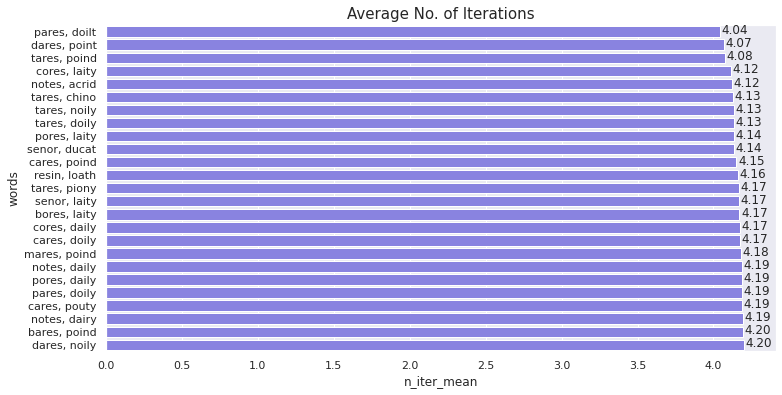

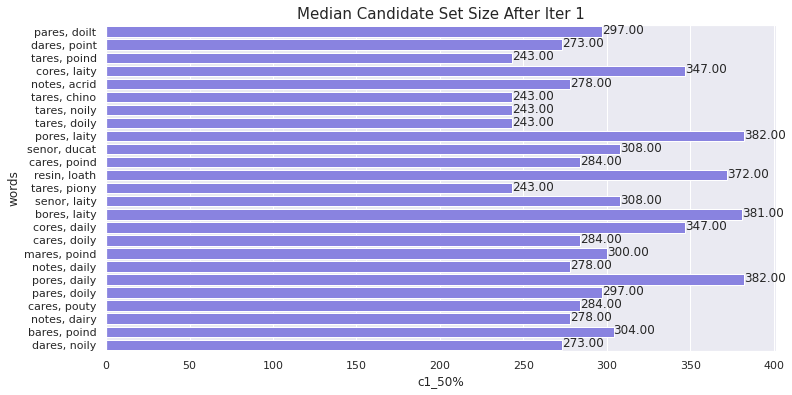

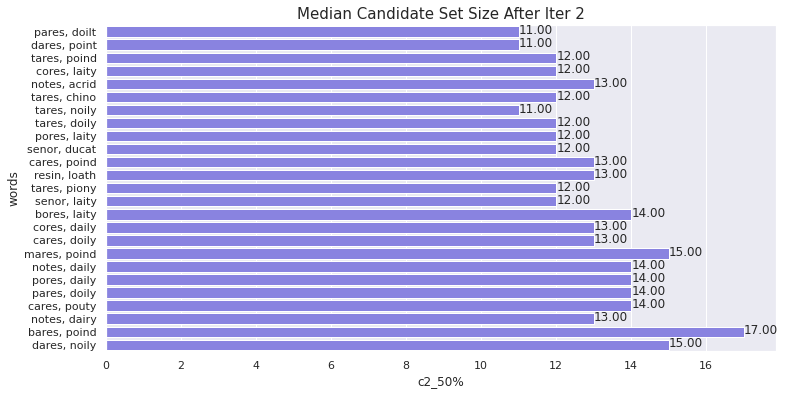

In [88]:
eval_results(df_pos_dbl_pop.sort_values('n_iter_mean').iloc[:25], single=False)

In [99]:
df_pos_dbl_pop.sort_values('n_iter_mean')

,words,word1,word2,n_iter_count,n_iter_mean,n_iter_std,n_iter_min,n_iter_25%,n_iter_50%,n_iter_75%,n_iter_max,iter_2_or_less,iter_3,iter_4,iter_5,iter_6,fail,c1_mean,c1_std,c1_min,c1_25%,c1_50%,c1_75%,c1_max,c2_mean,c2_std,c2_min,c2_25%,c2_50%,c2_75%,c2_max
11,"pares, doilt",pares,doilt,2315.0,4.044060,0.873974,3.0,3.0,4.0,5.0,10.0,0.000000,0.275162,0.471706,0.201296,0.041469,0.010367,361.605616,307.049687,1.0,100.0,297.0,475.0,972.0,18.213823,20.375231,1.0,4.0,11.0,25.0,131.0
40,"dares, point",dares,point,2315.0,4.069114,0.933609,2.0,3.0,4.0,5.0,9.0,0.000432,0.279914,0.461339,0.190497,0.049676,0.018143,340.219870,299.745486,2.0,91.0,273.0,476.0,988.0,20.337797,24.012132,0.0,4.0,11.0,28.0,140.0
13,"tares, poind",tares,poind,2315.0,4.076890,0.926960,3.0,3.0,4.0,5.0,9.0,0.000000,0.276458,0.458315,0.200000,0.047516,0.017711,284.119222,258.666597,1.0,82.0,243.0,402.0,858.0,20.779266,23.859338,1.0,4.0,12.0,29.0,140.0
17,"cores, laity",cores,laity,2315.0,4.117063,0.945187,3.0,3.0,4.0,5.0,10.0,0.000000,0.261771,0.455724,0.212527,0.051404,0.018575,393.517927,363.089765,1.0,94.0,347.0,477.0,1191.0,18.739525,19.888496,1.0,5.0,12.0,24.0,148.0
45,"notes, acrid",notes,acrid,2315.0,4.123110,0.926400,2.0,4.0,4.0,5.0,10.0,0.000432,0.247084,0.474298,0.209935,0.050540,0.017711,410.660907,360.920570,1.0,121.0,278.0,658.0,1129.0,22.921382,26.312067,0.0,5.0,13.0,34.0,201.0
16,"tares, chino",tares,chino,2315.0,4.127862,0.965291,3.0,3.0,4.0,5.0,9.0,0.000000,0.273002,0.430238,0.219006,0.057019,0.020734,284.119222,258.666597,1.0,82.0,243.0,402.0,858.0,24.319654,29.756876,1.0,4.0,12.0,33.0,201.0
14,"tares, noily",tares,noily,2315.0,4.132181,0.970514,3.0,3.0,4.0,5.0,10.0,0.000000,0.262635,0.452268,0.204752,0.059611,0.020734,284.119222,258.666597,1.0,82.0,243.0,402.0,858.0,17.409935,17.477878,1.0,5.0,11.0,23.0,134.0
12,"tares, doily",tares,doily,2315.0,4.133909,0.951387,3.0,3.0,4.0,5.0,10.0,0.000000,0.256156,0.456156,0.212527,0.054428,0.020734,284.119222,258.666597,1.0,82.0,243.0,402.0,858.0,18.552484,18.584205,1.0,5.0,12.0,24.0,154.0
29,"pores, laity",pores,laity,2315.0,4.135637,0.941553,3.0,3.0,4.0,5.0,9.0,0.000000,0.256587,0.449244,0.220302,0.054860,0.019006,436.752916,396.695726,1.0,109.5,382.0,468.0,1252.0,20.660907,21.527723,1.0,5.0,12.0,29.0,149.0
55,"senor, ducat",senor,ducat,2315.0,4.136069,0.916133,3.0,4.0,4.0,5.0,9.0,0.000000,0.239741,0.472570,0.224190,0.045356,0.018143,389.108423,313.554694,1.0,111.0,308.0,570.0,1003.0,27.039309,33.736302,1.0,5.0,12.0,36.0,189.0
